# AMP-BERT: fine-tuning de un modelo de lenguaje

En esta libreta de Jupyter se explican brevemente los métodos usados para reproducir el modelo AMP-BERT: una arquitectura basada en un modelo de lenguaje aplicado al problema del reconocimiento de péptidos antimicrobianos. El paper en el que se describe el modelo original se puede encontrar en https://onlinelibrary.wiley.com/doi/full/10.1002/pro.4529.

### Introducción: modelo original, detalles y características

El modelo original, un clasificador basado en un BERT, se puede obtener directamente de la librería *Transformers*. Permite clasificar una cadena de aminoácidos en función de su actividad antimicrobiana: AMP o no AMP. 

In [1]:
from transformers import BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [2]:
print(bert_model)
print(bert_model.config)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e

Esta salida es muy larga, así que la resumimos:

  - El modelo está formado por: 
     - Un submodelo codificador basado en BERT, que conforma casi la totalidad del modelo, a su vez formado por:
         - Una capa que añade la codificación posicional y de tipo de token a los tokens iniciales (llamada BertEmbeddings porque crea los embeddings iniciales)
         - Una lista de 30 capas BertLayer, que codifican la entrada usando el mecanismo de autoatención, con 16 cabezas cada una 
         - Una capa Pooler que obtiene el token codificado [CLS], que representa a la secuencia como embedding en $\mathbb{R}^{1024}$
     - Una capa de Dropout con probabilidad de drop 0
     - Una capa lineal, que actúa como clasificador lineal
     
La siguiente imagen resume el contenido del modelo original:

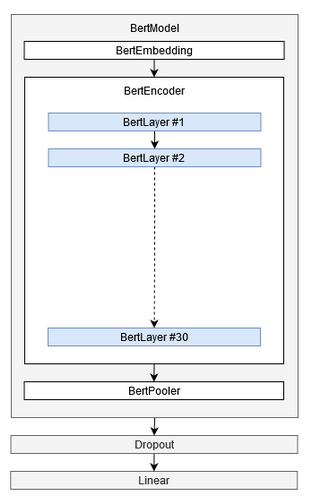

In [3]:
from IPython.display import Image
Image(filename='Bert_arch.png') 

### Creación del modelo a usar

Debido a las limitaciones de los recursos hardware disponibles, es necesario configurar un modelo que pueda usar dos tarjetas gráficas en lugar de una. Introducimos así el modelo MultiGPUBert, que tiene las siguientes características:

  - Copia en la medida de lo posible la arquitectura original de la implementación de un modelo BERT de la librería *Transformers*, usada para entrenar LLMs en Python
    
  - Reduce o elimina el código de las features no usadas para nuestros objetivos.
    
  - Introduce el paralelismo de modelos, o *model parallelism*, para separar las capas del modelo y distribuirlas en las dos GPUs disponibles

Se ilustran en una imagen todos los cambios que se van a realizar

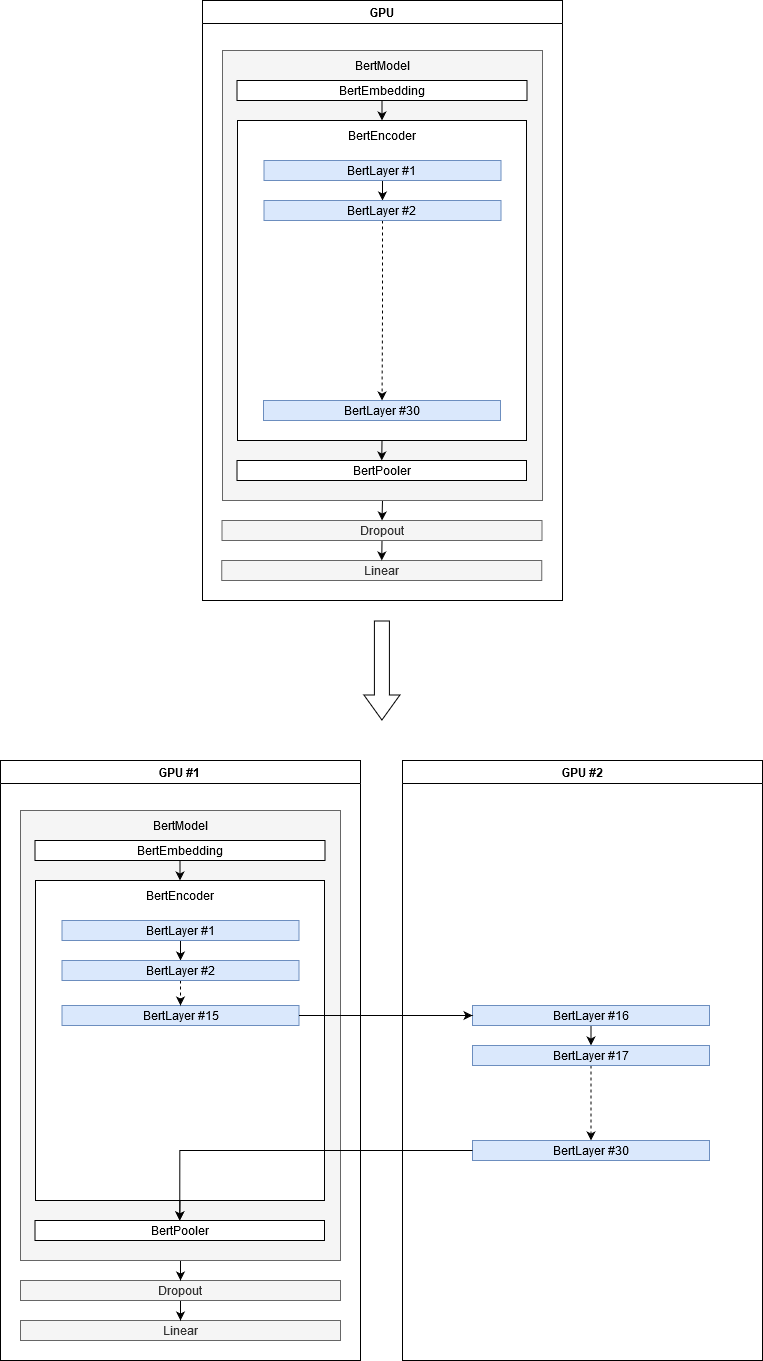

In [4]:
from IPython.display import Image
Image(filename='MultiGPUBert.png') 

In [5]:
import torch
from torch import nn
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions


def change_device(device, *tensors):
    r"""
        Cambia a un dispositivo una serie de tensores de PyTorch. Devuelve los tensores cambiados.
        Básicamente llama al método 'to(device)' en cada tensor, pero así se evita escribir mucho código.
        
        Bonus: si pones algo que no es un tensor, no le hace nada
        
        device   -- una cadena con el dispositivo al que cambiarlos (p.ej. 'cuda:0')
        tensors  -- lista variable de tensores de PyTorch

        Uso de ejemplo: outputs_gpu0, attentions_gpu0 = change_devices('cuda:0', outputs, attentions)
    """
    changed = ()
    for t in tensors:
        if t is not None and isinstance(t, torch.Tensor):
            t = t.to(device)
        changed = changed + (t,)
    return changed

class MultiGPUBertEncoder(nn.Module):

    def __init__(self, encoder):
        r"""
            Copia un encoder, dividiendolo en dos partes, que van a sendas GPUs.
        """
        super().__init__()
        self.config = encoder.config
        
        num_layers_1 = self.config.num_hidden_layers // 2
        self.layer1 = nn.ModuleList(encoder.layer[:num_layers_1]).to("cuda:0")
        self.layer2 = nn.ModuleList(encoder.layer[num_layers_1:]).to("cuda:1")
        
        self.gradient_checkpointing = encoder.gradient_checkpointing

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
    
        # Inicializaciones de variables
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        # Warning sin importancia
        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        next_decoder_cache = () if use_cache else None
        
        # PASO TODOS LOS TENSORES A LA GPU 0
        
        hidden_states, attention_mask, head_mask, encoder_hidden_states, encoder_attention_mask, past_key_values = change_device(
            "cuda:0", 
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_values
        )
        
        # TRABAJO CON LA GPU 0

        for i, layer_module in enumerate(self.layer1):

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        # AHORA ME CAMBIO A LA GPU 1 
        
        hidden_states, attention_mask, head_mask, encoder_hidden_states, encoder_attention_mask, past_key_values = change_device(
            "cuda:1", 
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_values
        )
                    
        # TRABAJO CON LA GPU 1 Y HAGO EXACTAMENTE LO MISMO
        
        for i, layer_module in enumerate(self.layer2):   
        
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)
            
        # ME VUELVO A LA GPU 0 COMO SI NADA HUBIERA PASADO
                    
        hidden_states, next_decoder_cache, all_hidden_states, all_self_attentions, all_cross_attentions = change_device(
            "cuda:0", 
            hidden_states, 
            next_decoder_cache,
            all_hidden_states,
            all_self_attentions,
            all_cross_attentions
        )

        # DEVUELVO LOS OUTPUTS OBTENIDOS
        
        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


Ahora que hemos paralelizado el BertEncoder, que ocupa la mayor parte de la memoria, es necesario replicar también las estructuras de código que permiten usar este codificador. Es decir, es necesaria una herramienta que, a partir de una entrada en forma de secuencia de palabras,

  - Genere los encajes o *embeddings* para dicha entrada usando el BertEncoder
  - Obtenga el embedding correspondiente al token [CLS] que devuelve el BertEncoder, y que representa la entrada codificada.
  - Use dicho embedding para entrenar un submodelo de clasificación en AMP o No-AMP
  
De nuevo aprovechamos el código fuente usado en la librería *Transformers* para crear estos modelos. Usamos una clase nueva que hereda y replica la herramienta descrita, pero que modifica su BertEncoder por el que hemos creado. Los cambios son mínimos

In [6]:
from transformers.models.bert.modeling_bert import BertModel

class MultiGPUBertModel(BertModel):
    def __init__(self, bert_model: BertModel):
        super(MultiGPUBertModel, self).__init__(bert_model.config)
        
        self.embeddings = bert_model.embeddings.to("cuda:0")
      # self.encoder = bert_model.encoder
        self.encoder = MultiGPUBertEncoder(bert_model.encoder)
        self.pooler = bert_model.pooler.to("cuda:0")

Ahora sólo queda diseñar un modelo de clasificación que pueda usar el modelo BERT, para la tarea que nos atañe. 

Usaremos una red neuronal básica de una sóla capa, un clasificador lineal. Esto nos permitirá comprobar el rendimiento de nuestra herramienta frente al del clasificador base ofrecido en la librería *Transformers*, que usa una herramienta similar. 

In [7]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

class MultiGPUBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, bert_model_for_sequence_classification):
        super(MultiGPUBertForSequenceClassification, self).__init__(bert_model_for_sequence_classification.config)
                
        self.num_labels = bert_model_for_sequence_classification.num_labels
        self.config = bert_model_for_sequence_classification.config

      # self.bert = BertModel(config)
        self.bert = MultiGPUBertModel(bert_model_for_sequence_classification.bert)

        self.dropout = nn.Dropout(0.01).to("cuda:0")
        self.classifier = nn.Linear(self.config.hidden_size, self.num_labels).to("cuda:0")
        
    def forward(
            self,
            input_ids: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            token_type_ids: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.Tensor] = None,
            head_mask: Optional[torch.Tensor] = None,
            inputs_embeds: Optional[torch.Tensor] = None,
            labels: Optional[torch.Tensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
        ) -> SequenceClassifierOutput:
            r"""
                Como el clasificador base de la librería, pero sin la morralla de devolver diccionarios si se lo pides (nunca)
            """
    
            # Paso los inputs por el bert para que me los devuelva codificados
            outputs = self.bert(
                input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
                
            # Aqui los recojo
            pooled_output = outputs[1]
    
            # Aplico dropout
            dropout_output = self.dropout(pooled_output)
            
            # Clasifico 
            logits = self.classifier(dropout_output)
            
            return SequenceClassifierOutput(
                loss=None,
                logits=logits,
                hidden_states=pooled_output,
                attentions=outputs.attentions,
            )


De esta forma hemos diseñado un modelo de clasificación de secuencias paralelizado en memoria a lo largo de dos GPUs. Ahora hay que ponerlo a prueba.

### Diseño del Pipeline para Fine-Tuning

Los pasos anteriores nos han llevado al diseño de un modelo de clasificación basado en un codificador BERT. Más aún, podemos tomar un modelo BERT de clasificación de secuencias basado en la librería *Transformers* y copiar sus pesos para usarlos con nuestro modelo. 

Ahora crearemos las herramientas necesarias para entrenarlo, tunearlo y validarlo. En concreto, necesitamos:

  - Estructuras de datos que permitan preprocesar las entradas
  - Un bucle de entrenamiento
  - Un bucle de test
  - Un medidor que permita comprobar el rendimiento del modelo
  
Vamos a ello:

#### Preprocesado de datos

Los modelos BERT necesitan que su entrada sea tokenizada, y además a la hora de entrenar los modelos un parámetro importante es el tamaño de lote o *batch size*. Por eso vamos a crear dos estructuras:

  - Un Dataset, que permita iterar sobre los datos de entrenamiento directamente preparados, de forma que se abstraiga el preprocesado inicial
  
  - Un Dataloader, que se encargue de empaquetar los datos en lotes o *batches*

In [8]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Define un Dataset y un Dataloader para preprocesar los ejemplos y formar minibatches con ellos, respectivamente

class AMP_Dataset(Dataset):
    """
        Esta clase permite formar un Dataset legible para los modelos de PyTorch
        Implementa los métodos necesarios para entrenar un BERT
    """
    def __init__(self, df, tokenizer_name='Rostlab/prot_bert_bfd', max_len=200):
        super(Dataset, AMP_Dataset).__init__(self)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name, do_lower_case=False)
        self.df = df
        self.max_len = max_len
        
        self.seqs = list(df['aa_seq'])
        self.labels = list(df['AMP'].astype(int))
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        seq = " ".join("".join(self.seqs[idx].split()))
        seq_enc = self.tokenizer(
            seq, 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_len,
            return_tensors = 'pt',
            return_attention_mask=True
        )
        seq_label = self.labels[idx]
        
        return {
            'input_ids': seq_enc['input_ids'].flatten(),
            'attention_mask' : seq_enc['attention_mask'].flatten(),
            'labels' : torch.tensor(seq_label, dtype=torch.long)
        }
    
class AMP_DataLoader(DataLoader):
    """
        Es una estructura de datos iterable con mini-batches de datos
    
        dataframe   --  Un dataframe de Pandas con los datos, con columnas 'aa_seq' y 'AMP'
        batch_size  --  El tamaño de mini-batch con el que vas a entrenar el modelo   
    """
    def __init__(self, dataframe, batch_size):
        DataLoader.__init__(
            self,
            AMP_Dataset(dataframe),
            batch_size = batch_size,
            num_workers = 4,
            shuffle = False
        )

#### Bucle de entrenamiento

Una vez que tenemos preparado un iterador sobre los datos, diseñamos un bucle de entrenamiento. Su funcionamiento es sencillo: para cada ejemplo se obtiene la predicción del modelo, se compara con la etiqueta real y se computa una función de pérdida que permite actualizar los gradientes de cada peso del modelo.

Además, se introduce un optimizador que aprovecha el valor de la función de pérdida para mejorar la búsqueda de los valores de los mejores pesos, así como un planificador (*scheduler*) que controla un decaimiento del *learning rate* a medida que avanzan las iteraciones.

In [9]:
# Funcion auxiliar para el calculo del loss
def compute_loss(loss_fn, outputs, labels):
    """ 
        Calcula el loss para realizar el backpropagation
    
        loss_fn -- Funcion de perdida
        outputs -- Los outputs del modelo tal cual        
        labels  -- Etiquetas reales
    """

    if isinstance(loss_fn, torch.nn.CrossEntropyLoss):
        # La CrossEntropy necesita todos los logits
        return loss_fn(outputs.logits, labels)
    elif isinstance(loss_fn, torch.nn.MSELoss):
        # El MSE necesita el softmax sobre la clase principal (el 1)
        preds = torch.softmax(outputs.logits, dim=1)[:,1:]
        return loss_fn(preds, labels.float())
    else:
        return None

from time import process_time_ns 

def train_model(model, data_loader, loss_fn, optimizer, scheduler, verbose = False):
    """
        Entrena un modelo, y devuelve etiquetas reales, predicciones y el loss final
        
        model         -- El modelo a entrenar
        data_loader   -- un dataloader con los ejemplos de entrenamiento
        loss_fn       -- La funcion de loss (MSE, CrossEntropy, etc.)
        optimizer     -- El optimizador del modelo
        scheduler     -- El scheduler del learning rate del optimizador
        verbose       -- True para mostrar informacion del entrenamiento por consola
    """
    
    model = model.train() # Explicitly setting model to train state
    labels = []
    predictions = []
    losses = []
    correct_predictions = 0
    
    # Variables para calcular una media del loss (no afecta al entrenamiento)
    mobile_loss = 0
    MOBILE_COEF = 0.9
    
    i = 0
    for d in data_loader:
        # Medimos el tiempo
        i = i + 1
        start = process_time_ns()

        # Obtenemos los atributos del siguiente batch
        input_ids = d['input_ids'].to("cuda:0")
        attention_mask = d['attention_mask'].to("cuda:0")
        targets = d['labels'].to("cuda:0")
        
        # Lo usamos como input para el modelo y obtenemos el output
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)

        # La predicción es la clase con mayor logit
        preds = torch.argmax(outputs.logits, dim = 1)
                
        # Guardamos la prediccion y la etiqueta real, para luego calcular metricas
        labels += targets.tolist()
        predictions += preds.tolist()
                
        # Calculamos el loss
        loss = compute_loss(loss_fn, outputs, targets)
        losses.append(loss.item())
        
        # Calculamos la media movil del loss
        mobile_loss = MOBILE_COEF*mobile_loss + (1-MOBILE_COEF)*loss.item()
        
        # Hacemos el backprop
        loss.backward()
        
        # Clip the gradients of the model to prevent exploding gradients using clip_grad_norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Medimos de nuevo
        end = process_time_ns()
        step_time = (end - start) // (10 ** 6)
        remaining_min = (step_time*(len(data_loader) - i) // (10 ** 3)) // 60
        remaining_sec = (step_time*(len(data_loader) - i) // (10 ** 3)) - remaining_min * 60

        # Imprimimos si es necesario
        if verbose:
            if i % 10 == 0:
                print(f"Step {i}/{len(data_loader)}: Loss (avg) {mobile_loss}, Step Time {step_time} ms, ETA {remaining_min}:{remaining_sec}")

    return labels, predictions, losses

#### Bucle de testing / validación

De forma paralela al bucle de entrenamiento es necesario desarrollar un método con el que obtener, a partir de un conjunto de test, el rendimiento del modelo. Lo hacemos de la siguiente forma:

In [10]:
def eval_model(model, data_loader, loss_fn, verbose = False):
    """
        Evalua un modelo con un conjunto de datos de test
        
        model         -- El modelo a entrenar
        data_loader   -- un dataloader con los ejemplos de entrenamiento
        loss_fn       -- La funcion de loss (MSE, CrossEntropy, etc.)
        verbose       -- True para mostrar informacion del entrenamiento por consola
    """
    model = model.eval()
    labels = []
    predictions = []
    
    # Variables para calcular una media del loss (no afecta al entrenamiento)
    mobile_loss = 0
    MOBILE_COEF = 0.9

    with torch.no_grad():
        i = 0
        for d in data_loader:
            # Medimos el tiempo
            i = i + 1
            start = process_time_ns()

            # Obtenemos los atributos del siguiente batch
            input_ids = d['input_ids'].to("cuda:0")
            attention_mask = d['attention_mask'].to("cuda:0")
            targets = d['labels'].to("cuda:0")
        
            # Lo usamos como input para el modelo y obtenemos el output
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)

            # La predicción es la clase con mayor logit
            preds = torch.argmax(outputs.logits, dim = 1)
                
            # Guardamos la prediccion y la etiqueta real, para luego calcular metricas
            labels += targets.tolist()
            predictions += preds.tolist()
            
            # Calculamos el loss
            loss = compute_loss(loss_fn, outputs, targets)
            
            # Calculamos la media movil del loss
            mobile_loss = MOBILE_COEF*mobile_loss + (1-MOBILE_COEF)*loss.item()
            
            # Medimos de nuevo
            end = process_time_ns()
            step_time = (end - start) // (10 ** 6)
            remaining_min = (step_time*(len(data_loader) - i) // (10 ** 3)) // 60
            remaining_sec = (step_time*(len(data_loader) - i) // (10 ** 3)) - remaining_min * 60
    
            # Imprimimos si es necesario
            if verbose:
                if i % 10 == 0:
                    print(f"Step {i}/{len(data_loader)}: Loss (avg) {mobile_loss}, Step Time {step_time} ms, ETA {remaining_min}:{remaining_sec}")

    return labels, predictions


#### Métricas para el rendimiento del modelo

Finalmente, queda preparar una forma de comprobar cómo se comporta el modelo frente a los datos de test. Si bien el bucle de test nos ofrece las predicciones frente a las etiquetas reales, es necesario procesar esta información para obtener la información relevante.

La siguiente función nos permite obtener varias de ellas

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from pandas import DataFrame

# Define una funcion para calcular métricas sobre etiquetas y predicciones

def compute_metrics(labels, preds):
    """ 
        Calcula métricas para evaluar el modelo tras un entrenamiento
    
        labels  -- Etiquetas reales
        preds   -- Etiquetas predichas (no logits ni valores no categóricos)
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    conf = confusion_matrix(labels, preds)
    tn, fp, fn, tp = conf.ravel()
    auroc = roc_auc_score(labels, preds)
    
    precision_data, recall_data, thresholds_data = precision_recall_curve(labels, preds)
    aupr = auc(recall_data, precision_data)
    
    measures = {
        'accuracy': [acc],
        'f1': [f1],
        'precision': [precision],
        'recall': [recall],
        'specificity': [tn / (tn+fp)],
        'auroc': [auroc],
        'aupr': [aupr],
        'confusion_matrix': [conf]
    }
    return DataFrame(measures)

### Herramientas adicionales: CrossValidation y Grid Search

El pipeline diseñado es útil para entrenar y testear. Ahora podemos usarlo para dos tareas frecuentes en Machine Learning:

#### CrossValidation

La crosvalidación consiste en el entrenamiento y validación de un modelo a partir de un conjunto de ejemplos, con diferentes particiones, seguida de una medición final. El objetivo es comprobar la existencia de indicios de overfitting en el modelo. Aquí se ofrece una función dedicada a ello:

In [12]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy
from itertools import product
from sklearn.model_selection import KFold
from copy import deepcopy
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from time import process_time_ns

def crossvalidate(model, train_dataframe, n_splits, n_repeats, model_params, loss_fn=torch.nn.CrossEntropyLoss(), verbose=True):
    """
        Crossvalida un modelo
        
        model           -- El modelo a crosvalidar
        train_dataframe -- un dataframe con los ejemplos de entrenamiento (y validacion)
        n_splits        -- Numero de particiones
        n_repeats       -- Numero de repeticiones de la crosvalidacion
        model_params    -- Diccionario con hiperparametros relevantes
        loss_fn         -- La funcion de loss (MSE, CrossEntropy, etc.)
        verbose         -- True para mostrar informacion del entrenamiento por consola
    """
    
    SEED = 0
    BATCH_SIZE = model_params["batch_size"]
    EPOCHS = model_params["epochs"]
    LR = model_params["learning_rate"]
    WARMUP_STEPS = model_params["warmup_steps"]
    WEIGHT_DECAY = model_params["weight_decay"]

    kf = StratifiedKFold(
        n_splits = n_splits,
        shuffle = True,
        random_state = SEED
    )
    
    best_metrics = pd.DataFrame({
        'f1': [0.0]
    })
    
    for i in range(n_repeats):
        if verbose:
            print(f"Crossvalidation: {i+1} repeat")
            print()
        
        # Separamos las secuencias de aminoacidos de la etiqueta para dividirlos
        seqs = train_dataframe['aa_seq']
        labels = train_dataframe['AMP']
        
        val_metrics = pd.DataFrame()
        
        j = 0
        # En esta repeticion entrenamos y evaluamos sobre cada division en train/validation
        for train_j, val_j in kf.split(seqs, labels):
            if verbose:
                j += 1
                print(f"Crossvalidation: {j} fold")
                print()
                
            # Reconstruir los dataframes
            train_df_j = pd.DataFrame({
                'aa_seq': seqs[train_j],
                'AMP': labels[train_j]
            }).sample(frac=1, random_state=SEED)
                        
            val_df_j = pd.DataFrame({
                'aa_seq': seqs[val_j],
                'AMP': labels[val_j]
            }).sample(frac=1, random_state=SEED)
            
            if verbose:
                train_dataloader = AMP_DataLoader(train_df_j, batch_size = BATCH_SIZE)
                print("Sample of train data for this split:")
                print(train_df_j.head(15))
                print()
            
                val_dataloader = AMP_DataLoader(val_df_j, batch_size = BATCH_SIZE)
                print("Sample of validation data for this split:")
                print(val_df_j.head(15))
                print()
            
            # Copiar el modelo para entrenarlo
            model_i = deepcopy(model)
            
            # Entrenar el modelo con esta configuracion
            optimizer_i = AdamW(model_i.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
            
            total_steps_i = len(train_dataloader) * EPOCHS
            
            scheduler_i = get_linear_schedule_with_warmup(optimizer_i, 
                                           num_warmup_steps = WARMUP_STEPS, 
                                           num_training_steps = total_steps_i)

            for i in range(EPOCHS):
                train_model(model_i, train_dataloader, loss_fn, optimizer_i, scheduler_i, verbose=False)

            # Obtener las métricas de validacion
            val_labels, val_preds = eval_model(model_i, val_dataloader, loss_fn, verbose=False)
            
            val_metrics_i = compute_metrics(val_labels, val_preds)
            
            if verbose:
                print(f"Metrics for fold {j}: ")
                print(val_metrics_i)
                print()
            
            val_metrics = pd.concat([val_metrics, val_metrics_i], ignore_index=True)
            
        # Una vez probado con cada division de train/validation en este set, calculamos la media de las metricas
        mean_metrics = val_metrics.mean(axis=0)
        if verbose:
            print(f"Mean metrics for repeat {i+1}: ")
            print(mean_metrics)
            print()
        
        if mean_metrics['f1'].item() >= best_metrics['f1'].item():
            best_metrics = mean_metrics
    
    return best_metrics

#### Grid Search

Esta técnica consiste en buscar, a partir de una serie de opciones para diversos hiperparámetros de un modelo, la mejor combinación de todas ellas basada en una métrica. 

Se ofrece un método con el que es posible llevar a cabo todo este proceso para el modelo que estamos usando, de forma transparente al usuario.

In [13]:
from itertools import product
from sklearn.model_selection import KFold
from copy import deepcopy
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from time import process_time_ns

def grid_search_bert_model(model, train_val_dataframe, grid, loss_fn = CrossEntropyLoss(), verbose = False):
        
    param_combinations = product(
        grid["epochs"],
        grid["batch_size"],
        grid["learning_rate"],
        grid["betas"],
        grid["epsilon"],
        grid["weight_decay"],
        grid["warmup_steps"]
    )
    
    all_combs = []
    all_metrics = []
    all_losses = []
        
    # Calculamos todas las combinaciones con el grid de hiperparametros
    num_combinations = 1
    for key in grid.keys():
        num_combinations *= len(grid[key])
    
    # Separamos en train y validacion
    TRAIN_FRAC = 0.8
    
    train_dataframe = train_val_dataframe.sample(frac=TRAIN_FRAC, random_state=SEED)
    val_dataframe = train_val_dataframe.drop(train_dataframe.index)
    
    print()
    print(f"Number of combinations: {num_combinations}")

    for combination in param_combinations:
        
        # En cada combinacion entrenamos y testeamos
        epochs, batch_size, learning_rate, betas, epsilon, weight_decay, warmup_steps = combination
        
        train_data_loader = AMP_DataLoader(train_dataframe, batch_size = batch_size)
        val_data_loader = AMP_DataLoader(val_dataframe, batch_size = batch_size)

        print()
        print("Next combination:")
        print(f"epochs: {epochs}")
        print(f"batch_size: {batch_size}")
        print(f"learning_rate: {learning_rate}")
        print(f"betas: {betas}")
        print(f"epsilon: {epsilon}")
        print(f"weight_decay: {weight_decay}")
        print(f"warmup_steps: {warmup_steps}")
        
        # Copiamos el modelo
        model_copy = deepcopy(model)
        
        # Preparamos el optimizador y el scheduler
        optimizer = AdamW(
            model_copy.parameters(), 
            lr = learning_rate,
            betas = betas,
            eps = epsilon,
            weight_decay = weight_decay
        )
        
        total_steps = len(train_data_loader) * epochs

        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = warmup_steps, 
                                           num_training_steps = total_steps)
        # Entrenamos
        train_start = process_time_ns()
        for epoch in range(epochs):
            _, _, losses = train_model(model_copy, train_data_loader, loss_fn, optimizer, scheduler, verbose)
        train_end = process_time_ns()
        
        # Medimos
        eval_start = process_time_ns()
        labels, predictions = eval_model(model_copy, val_data_loader, loss_fn, verbose)
        eval_end = process_time_ns()

        metrics = compute_metrics(labels, predictions)
        metrics["train_time_secs"] = (train_end - train_start) // (10 ** 9)
        metrics["eval_time_secs"] = (eval_end - eval_start) // (10 ** 9)
        
        # Guardamos las medidas
        all_combs.append(combination)
        all_metrics.append(metrics)
        all_losses.append(losses)
                    
        del model_copy
        
    df_combs = pd.DataFrame(all_combs, index = range(num_combinations), columns=['epochs', 'batch_size', 'learning_rate', 'betas', 'epsilon', 'weight_decay', 'warmup_steps'])
    df_metrics = pd.concat(all_metrics)
    df_metrics.index = range(num_combinations)
    df_results = pd.concat([df_combs, df_metrics], axis=1)
    
    df_losses = pd.DataFrame(all_losses, index = range(num_combinations))
    
    return df_results, df_losses

### Clasificación de péptidos básica

Con todas estas herramientas ya se puede llevar a cabo una tarea de clasificación a partir de un conjunto de datos iniciales. Con los datos obtenidos a partir de https://github.com/GIST-CSBL/AMP-BERT se ha llevado a cabo un proceso de Fine Tuning del modelo presentado. En las siguientes celdas de código se muestra un Grid Search con el que además se buscan los mejores hiperparámetros para el modelo, de un conjunto preestablecido. Este Grid Search incluye la combinación de parámetros que se reporta como la mejor combinación, así como algunas combinaciones diferentes a las que estudia el paper inicial.

En particular, nuestros primeros objetivos son los siguientes:

  - Replicar los resultados obtenidos en el paper de AMP-BERT o mejorarlos
  - Dar una base mayor de hiperparámetros sobre la que trabajar con el modelo

A partir de los resultados obtenidos se elaborarán gráficas con las que presentar la información obtenida.

#### Paso 1: obtener los datos

Los datos de training de los que disponemos inicialmente consisten en 3556 ejemplos (etiquetados con AMP o No AMP) balanceados: 50% positivos y 50% negativos. Los datos de test son similares. Teniendo en cuenta que no existen ejemplos repetidos, realmente podemos distribuirlos como queramos.

In [14]:
import pandas as pd

# Se leen los datos de train y test
SEED = 0

train_df = pd.read_csv('./datasets/all_veltri.csv', index_col = 0).sample(frac=1, random_state=SEED)
test_df_pos = pd.read_csv('./datasets/veltri_dramp_cdhit_90.csv', index_col = 0)
test_df_neg = pd.read_csv('./datasets/non_amp_ampep_cdhit90.csv', index_col = 0)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1, random_state=SEED)

# Imprimimos el numero de coincidencias: es cero
print(f"Numero de coincidencias: {len([(i,j) for i,j in zip(range(len(train_df)),range(len(test_df))) if train_df['aa_seq'][i] == test_df['aa_seq'][j]])}")

print(train_df.head(7))


Numero de coincidencias: 0
                                                            aa_seq  aa_len  \
AP02151          YEALVTSILGKLTGLWHNDSVDFMGHICYFRRRPKIRRFKLYHEGK...      95   
AP01951                                          FLPLVLGALSGILPKIL      17   
AP00972                                        FLSLIPHAINAVGVHAKHF      19   
AP01261                                           IIEKLVNTALGLLSGL      16   
AP01298                                       GLFTLIKCAYQLIAPTVACN      20   
AP01802                                     RPWAGNGSVHRYTVLSPRLKTQ      22   
UniRef50_Q9UTR1                                SKENSYVEKLLYKQRFYAS      19   

                   AMP  
AP02151           True  
AP01951           True  
AP00972           True  
AP01261           True  
AP01298           True  
AP01802           True  
UniRef50_Q9UTR1  False  


#### Paso 2: buscar en un grid de hiperparámetros

Ahora hay que inicializar el modelo que hemos creado, y crear un grid de hiperparámetros sobre el que buscar. En este grid modificaremos:

  - Epochs: el número de épocas indica cuántas pasadas se harán por los datos. No es determinante para obtener un modelo de buen rendimiento, sino que se comprueba con el resto de hiperparámetros fijos para maximizar el rendimiento sobre un modelo que ya es bueno. Dado que estamos comprobando la eficacia del método, probaremos también con pocos epochs. 

  - Learning rate: este parámetro es crucial para el entrenamiento del modelo. Necesitamos que sea lo suficientemente grande como para que haya una actualización significativa de los pesos y no se caiga en mínimos locales, pero lo suficientemente pequeño como para que los pesos no se disparen de forma descontrolada.
  
  - Weight Decay: este parámetro controla el decaimiento de los pesos en función del learning rate. Su valor afecta a cómo se aplica el learning rate sobre los pesos, luego hay que tenerlo en cuenta.
  
El resto de hiperparámetros no se variará por las siguientes razones:

  - Batch size: en el paper original se usa un tamaño de batch de 32, que se considera suficientemente pequeño. Nuestros recursos no dejan usar un batch_size mayor que 8, así que usaremos este tamaño y posteriormente haremos un estudio acerca del tamaño de batch que podemos usar y cómo varían los resultados con él.

  - Warm-up steps: en el paper original es posible observar que las combinaciones que mejores valores obtienen son aquellas en las que no se usan pasos de calentamiento, de forma que no se observa necesidad de mostrar valores diferentes de 0 para este hiperparámetro. 
  
  - Betas: se trata de parámetros internos del optimizador AdamW que tienen que ver con el *momentum* o inercia del método de gradiente descendente. Es lo suficientemente específico como para revisarlo una vez no haya nada más que mejorar.
  
  - Epsilon: se trata del valor que la máquina considera como "suficientemente pequeño", y es relevante cuando se usa coma flotante de pocos bits (8,16). Lo dejamos en el valor por defecto (tengamos en cuenta que los numeros más pequeños que una máquina de 64 bits puede almacenar son del orden de $10^{-15}$.

In [15]:
# Inicializo el modelo
bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
multi_gpu_bert = MultiGPUBertForSequenceClassification(bert_model)

grid = {
    "epochs": [1, 4, 15],
    "learning_rate": [5e-4, 5e-5, 5e-6, 5e-7],
    "weight_decay": [0.1, 0.01],
    "batch_size": [8],
    "warmup_steps": [0],
    "betas": [(0.9, 0.999)],
    "epsilon": [1e-8],
}

# Busco en un grid
grid_search_results, grid_search_losses = grid_search_bert_model(multi_gpu_bert, train_df, grid)

print()
print("Resultados:")
print(grid_search_results)

grid_search_results.to_csv('results/grid_search_results.csv', index=False)
grid_search_losses.to_csv('results/grid_search_losses.csv', index=False)  

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init


Number of combinations: 24

Next combination:
epochs: 1
batch_size: 8
learning_rate: 0.0005
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 1
batch_size: 8
learning_rate: 0.0005
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 1
batch_size: 8
learning_rate: 5e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 1
batch_size: 8
learning_rate: 5e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 1
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 1
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 1
batch_size: 8
learning_rate: 5e-07
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 1
batch_s

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Next combination:
epochs: 4
batch_size: 8
learning_rate: 0.0005
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Next combination:
epochs: 4
batch_size: 8
learning_rate: 5e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 4
batch_size: 8
learning_rate: 5e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 4
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 4
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 4
batch_size: 8
learning_rate: 5e-07
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 4
batch_size: 8
learning_rate: 5e-07
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 15
batch_size: 8
learning_rate: 0.0005
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Next combination:
epochs: 15
batch_size: 8
learning_rate: 0.0005
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Next combination:
epochs: 15
batch_size: 8
learning_rate: 5e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 15
batch_size: 8
learning_rate: 5e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Next combination:
epochs: 15
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 15
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Next combination:
epochs: 15
batch_size: 8
learning_rate: 5e-07
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
warmup_steps: 0

Next combination:
epochs: 15
batch_size: 8
learning_rate: 5e-07
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0

Resultados:
    epochs  batch_size  learning_rate         betas       epsilon  \
0        1           8   5.000000e-04  (0.9, 0.999)  1.000000e-08   
1        1           8   5.000000e-04  (0.9, 0.999)  1.000000e-08   
2        1           8   5.000000e-05  (0.9, 0.999)  1.000000e-08   
3        1           8   5.000000e-05  (0.9, 0.999)  1.000000e-08   
4        1           8   5.000000e-06  (0.9, 0.999)  1.000000e-08   
5        1           8   5.000000e-

De esta forma, las medidas obtenidas han sido las siguientes. Se omiten los parámetros por defecto y el batch_size.

|epochs|learning_rate|weight_decay|warmup_steps|accuracy          |f1                |precision         |recall            |specificity        |auroc             |aupr              |train_time_secs|eval_time_secs|
|------|-------------|------------|------------|------------------|------------------|------------------|------------------|-------------------|------------------|------------------|---------------|--------------|
|1     |0.0005       |0.1         |0           |0.5189873417721519|0.6833333333333332|0.5189873417721519|1.0               |0.0                |0.5               |0.759493670886076 |259            |21            |
|1     |0.0005       |0.01        |0           |0.5189873417721519|0.6833333333333332|0.5189873417721519|1.0               |0.0                |0.5               |0.759493670886076 |259            |21            |
|1     |5e-05        |0.1         |0           |0.9071729957805907|0.9062500000000001|0.9522388059701492|0.8644986449864499|0.9532163742690059 |0.9088575096277278|0.9435304695008031|260            |21            |
|1     |5e-05        |0.01        |0           |0.8987341772151899|0.9064935064935065|0.8703241895261845|0.94579945799458  |0.847953216374269  |0.8968763371844246|0.9221265213693838|260            |21            |
|1     |5e-06        |0.1         |0           |0.919831223628692 |0.9196050775740481|**0.9588235294117647**|0.8834688346883469|**0.9590643274853801** |0.9212665810868635|0.9513852819094089|260            |21            |
|1     |5e-06        |0.01        |0           |0.9127988748241913|0.913649025069638 |0.9398280802292264|0.8888888888888888|0.9385964912280702 |0.9137426900584795|0.9431911146575104|260            |21            |
|1     |5e-07        |0.1         |0           |0.5189873417721519|0.6833333333333332|0.5189873417721519|1.0               |0.0                |0.5               |0.759493670886076 |260            |21            |
|1     |5e-07        |0.01        |0           |0.5189873417721519|0.6833333333333332|0.5189873417721519|1.0               |0.0                |0.5               |0.759493670886076 |261            |21            |
|4     |0.0005       |0.1         |0           |0.4810126582278481|0.0               |0.0               |0.0               |1.0                |0.5               |0.759493670886076 |1042           |21            |
|4     |0.0005       |0.01        |0           |0.4810126582278481|0.0               |0.0               |0.0               |1.0                |0.5               |0.759493670886076 |1042           |21            |
|4     |5e-05        |0.1         |0           |0.8185654008438819|0.8443908323281062|0.7608695652173914|0.948509485094851 |0.6783625730994152 |0.8134360290971331|0.8680509878846725|1045           |21            |
|4     |5e-05        |0.01        |0           |0.680731364275668 |0.7632950990615224|0.6203389830508474|**0.991869918699187** |0.34502923976608185|0.6684495792326344|0.8082141555163674|1045           |21            |
|4     |5e-06        |0.1         |0           |0.9268635724331927|0.9299191374663072|0.9249329758713136|0.9349593495934959|0.9181286549707602 |0.9265440022821282|0.9468237998632064|1046           |21            |
|4     |5e-06        |0.01        |0           |0.9367088607594937|0.9392712550607287|0.9354838709677419|0.943089430894309 |0.9298245614035088 |0.9364569961489089|0.954054583420477 |1045           |21            |
|4     |5e-07        |0.1         |0           |0.919831223628692 |0.9211618257261411|0.940677966101695 |0.9024390243902439|0.9385964912280702 |0.920517757809157 |0.9468749509421721|1046           |21            |
|4     |5e-07        |0.01        |0           |0.9156118143459916|0.9168975069252077|0.9376770538243626|0.8970189701897019|0.935672514619883  |0.9163457424047924|0.9440709374641348|1046           |21            |
|15    |0.0005       |0.1         |0           |0.4810126582278481|0.0               |0.0               |0.0               |1.0                |0.5               |0.759493670886076 |3911           |21            |
|15    |0.0005       |0.01        |0           |0.4810126582278481|0.0               |0.0               |0.0               |1.0                |0.5               |0.759493670886076 |3913           |21            |
|15    |5e-05        |0.1         |0           |0.8171589310829818|0.8065476190476191|0.8943894389438944|0.7344173441734417|0.9064327485380117 |0.8204250463557268|0.883320409842775 |3919           |21            |
|15    |5e-05        |0.01        |0           |0.4810126582278481|0.0               |0.0               |0.0               |1.0                |0.5               |0.759493670886076 |3915           |21            |
|15    |5e-06        |0.1         |0           |0.9353023909985936|0.9380053908355794|0.9329758713136729|0.943089430894309 |0.9269005847953217 |0.9349950078448154|0.9528005835934423|3928           |21            |
|15    |5e-06        |0.01        |0           |0.939521800281294 |**0.9416553595658074**|0.9429347826086957|0.940379403794038 |0.9385964912280702 |**0.939487947511054** |**0.9571282605712684**|3929           |21            |
|15    |5e-07        |0.1         |0           |0.9184247538677919|0.9220430107526881|0.9146666666666666|0.9295392953929539|0.9064327485380117 |0.9179860219654827|0.9403870879215122|3928           |21            |
|15    |5e-07        |0.01        |0           |0.9184247538677919|0.9220430107526881|0.9146666666666666|0.9295392953929539|0.9064327485380117 |0.9179860219654827|0.9403870879215122|3929           |21            |

Mejores parámetros:

Por F1, área bajo la curva ROC y área bajo la curva Precisión-Recall:

|epochs|learning_rate|weight_decay|warmup_steps|accuracy          |f1                |precision         |recall            |specificity        |auroc             |aupr              |train_time_secs|eval_time_secs|
|------|-------------|------------|------------|------------------|------------------|------------------|------------------|-------------------|------------------|------------------|---------------|--------------|
|15    |5e-06        |0.01        |0           |0.939521800281294 |**0.9416553595658074**|0.9429347826086957|0.940379403794038 |0.9385964912280702 |**0.939487947511054** |**0.9571282605712684**|3929           |21            |

Por precisión y especificidad:

|epochs|learning_rate|weight_decay|warmup_steps|accuracy          |f1                |precision         |recall            |specificity        |auroc             |aupr              |train_time_secs|eval_time_secs|
|------|-------------|------------|------------|------------------|------------------|------------------|------------------|-------------------|------------------|------------------|---------------|--------------|
|1     |5e-06        |0.1         |0           |0.919831223628692 |0.9196050775740481|**0.9588235294117647**|0.8834688346883469|**0.9590643274853801** |0.9212665810868635|0.9513852819094089|260            |21            |

Por recall:

|epochs|learning_rate|weight_decay|warmup_steps|accuracy          |f1                |precision         |recall            |specificity        |auroc             |aupr              |train_time_secs|eval_time_secs|
|------|-------------|------------|------------|------------------|------------------|------------------|------------------|-------------------|------------------|------------------|---------------|--------------|
|4     |5e-05        |0.01        |0           |0.680731364275668 |0.7632950990615224|0.6203389830508474|**0.991869918699187** |0.34502923976608185|0.6684495792326344|0.8082141555163674|1045           |21            |

El resultado general es positivo: se han alcanzado las métricas reportadas en el estudio, que es lo que se buscaba. Los indicadores generales que balancean todas las métricas apuntan a que la mejor combinación es similar a la indicada en el estudio. Cabe destacar que el learning rate es algo menor, puesto que también se ha usado un batch_size menor. Al mismo tiempo, la elección de un weight_decay algo inferior también ha resultado efectiva para mejorar a la combinación con weight_decay mayor. 

Ahora visualizamos los datos obtenidos:

In [41]:
import pandas as pd

grid_search_results = pd.read_csv('results/grid_search_results.csv')
grid_search_losses = pd.read_csv('results/grid_search_losses.csv')  

#### Paso 3: analizar las medidas obtenidas en la búsqueda

Se muestran a continuación una serie de diagramas de barras en los que aparecen las medidas obtenidas para cada configuración. 

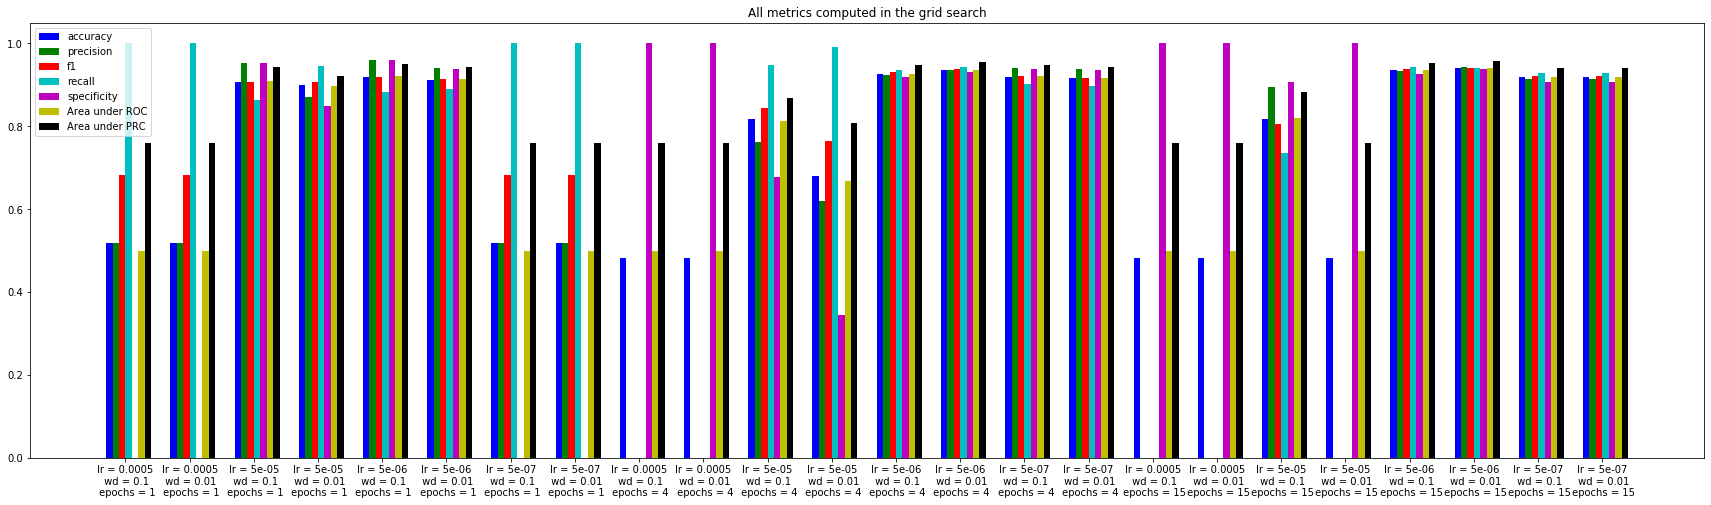

In [20]:
import matplotlib.pyplot as plt
import numpy as np

index = np.arange(len(grid_search_results["learning_rate"]))
tags = [f"lr = {grid_search_results['learning_rate'][i]}\n wd = {grid_search_results['weight_decay'][i]}\n epochs = {grid_search_results['epochs'][i]}" for i in index]

w = 0.1

plt.figure(figsize=(30,8))

plt.bar(index - 3*w, grid_search_results["accuracy"], color="b", label="accuracy", width=w)
plt.bar(index - 2*w, grid_search_results["precision"],  color="g", label="precision", width=w)
plt.bar(index - 1*w, grid_search_results["f1"], color="r", label="f1", width=w)
plt.bar(index + 0*w, grid_search_results["recall"], color="c", label="recall", width=w)
plt.bar(index + 1*w, grid_search_results["specificity"], color="m", label="specificity", width=w)
plt.bar(index + 2*w, grid_search_results["auroc"], color="y", label="Area under ROC", width=w)
plt.bar(index + 3*w, grid_search_results["aupr"], color="k", label="Area under PRC", width=w)

plt.xticks(index - w/2, tags)
plt.legend()
plt.title("All metrics computed in the grid search")
plt.show()

Las primeras conclusiones que sacamos son las siguientes:

  - Elegir un learning rate demasiado alto ($learning\_rate\,=5\cdot10^{-4}$) supone un desajuste de los pesos que hace que se obtenga un *accuracy* del 50%, y un *recall* o una *specificiy* del 100%. Esto indica que el modelo acaba aprendiendo a predecir siempre positivo o negativo. Por tanto, este valor es cota superior para el valor óptimo de este hiperparámetro

  - En los casos $learning\_rate\,=\,10^{-7}$ se obtiene un *accuracy* del 50%, y un *recall* del 100% con pocos epochs, pero buenas métricas con más epochs. Esto significa que el modelo tarda más en aprender a clasificar los ejemplos, y es peor que valores más altos. Por tanto, este valor es cota inferior para el valor óptimo de este hiperparámetro
  
  - El *weight_decay* del modelo no parece un hiperparámetro que tenga un efecto muy significativo en el rendimiento del modelo: las diferencias son casi inapreciables, a pesar de que hemos usado valores muy distantes entre sí ($0.1$ es diez veces mayor que $0.01$, el valor por defecto, y aun así los resultados son muy similares). El hecho de que la mejor combinación tenga $weight\_decay = 0.01$ indica, aun así, que no se debe subestimar su efecto.
  
Ploteamos cada métrica por separado:

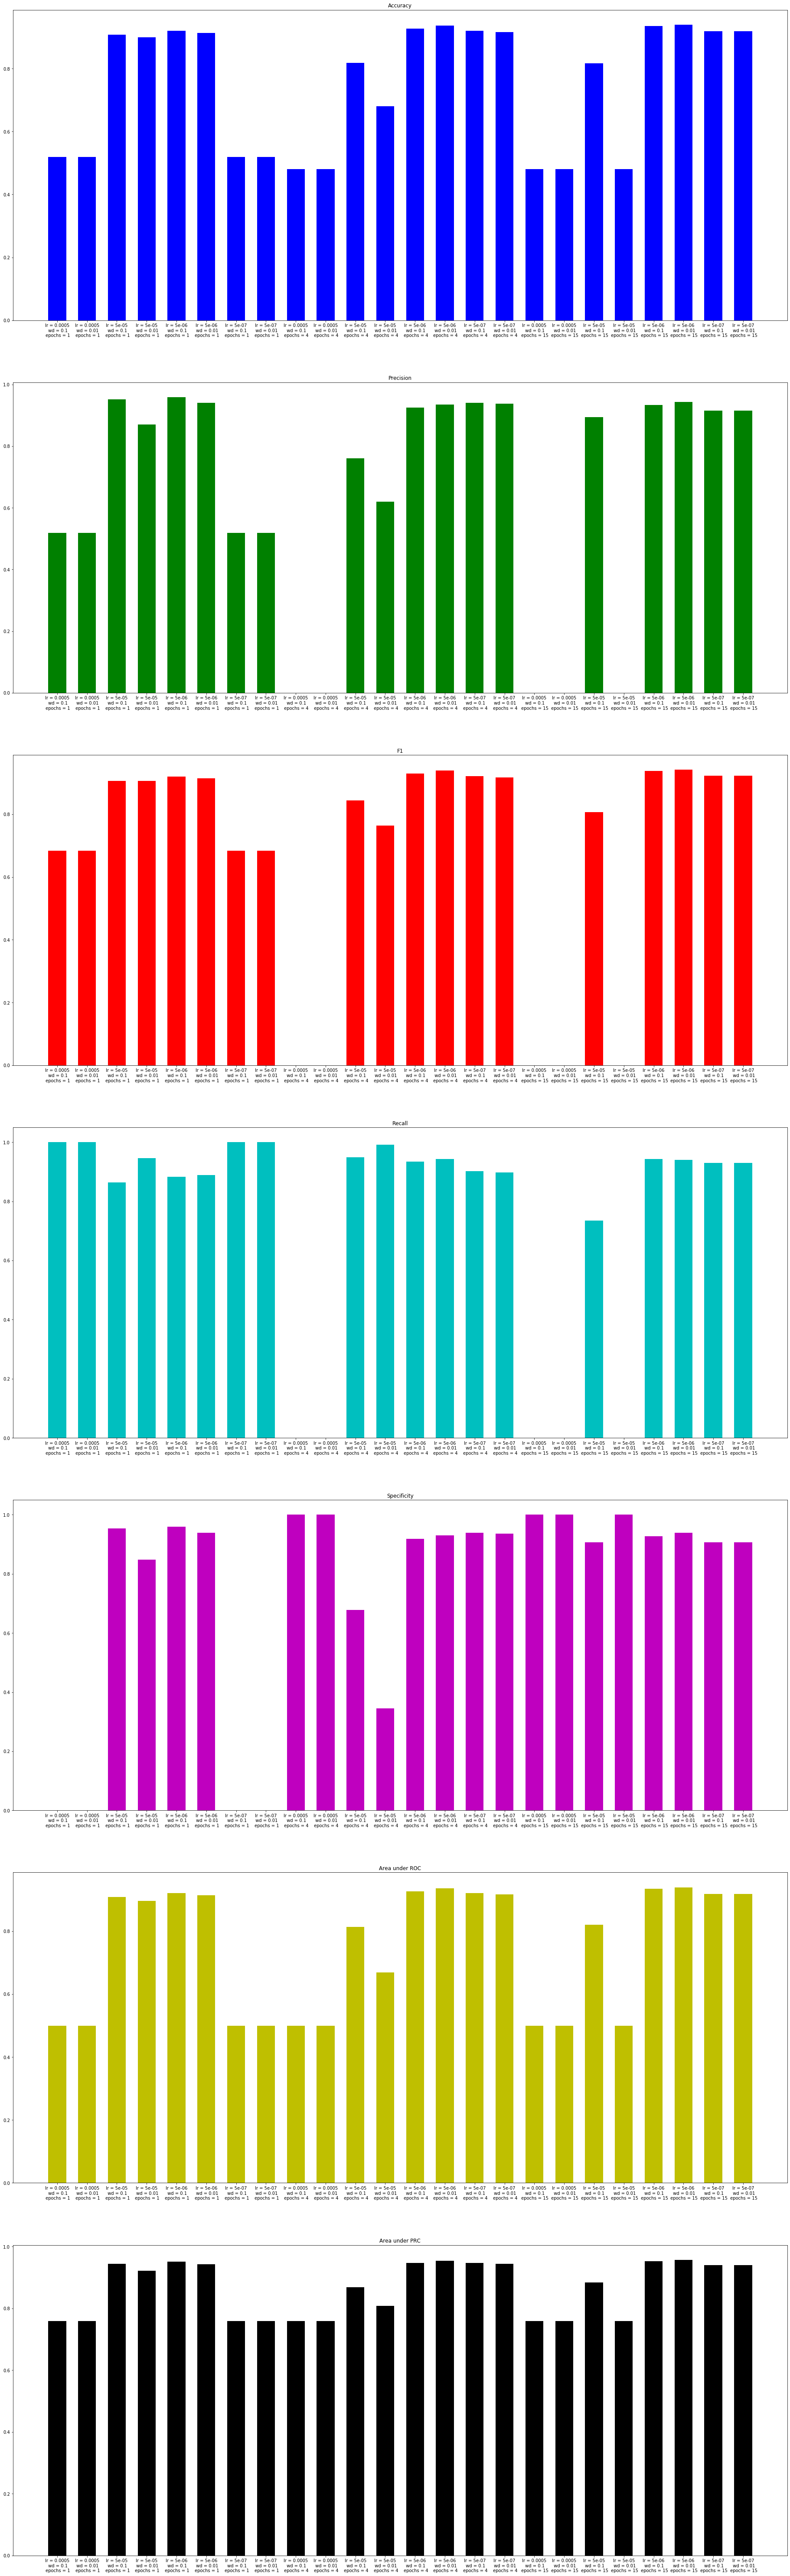

In [26]:
fig, axs = plt.subplots(7, figsize=(32, 108))

w = 0.6

axs[0].bar(index, grid_search_results["accuracy"], color='b', width=w)
axs[0].set_title("Accuracy")
axs[0].set_xticks(index)
axs[0].set_xticklabels(tags)

axs[1].bar(index, grid_search_results["precision"], color='g', width=w)
axs[1].set_title("Precision")
axs[1].set_xticks(index)
axs[1].set_xticklabels(tags)

axs[2].bar(index, grid_search_results["f1"], color='r', width=w)
axs[2].set_title("F1")
axs[2].set_xticks(index)
axs[2].set_xticklabels(tags)
        
axs[3].bar(index, grid_search_results["recall"], color='c', width=w)
axs[3].set_title("Recall")
axs[3].set_xticks(index)
axs[3].set_xticklabels(tags)

axs[4].bar(index, grid_search_results["specificity"], color='m', width=w)
axs[4].set_title("Specificity")
axs[4].set_xticks(index)
axs[4].set_xticklabels(tags)

axs[5].bar(index, grid_search_results["auroc"], color='y', width=w)
axs[5].set_title("Area under ROC")
axs[5].set_xticks(index)
axs[5].set_xticklabels(tags)

axs[6].bar(index, grid_search_results["aupr"], color='k', width=w)
axs[6].set_title("Area under PRC")
axs[6].set_xticks(index)
axs[6].set_xticklabels(tags)

plt.show()

#### Paso 4: Analizar la evolución la evolución del loss para cada configuración

A continuación se muestran algunas gráficas en las que se analiza cómo se comporta la pérdida con la crossentropía. Primero hacemos algunas gráficas sencillas en las que se plotea, para cada configuración de hiperparámetros probada, la serie temporal de pérdida con respecto a los ejemplos de entrenamiento. Es decir, para cada ejemplo, la pérdida del modelo tras predecirlo a lo largo del entrenamiento.

Se usarán las configuraciones que usan una sóla época, de forma que las gráficas se puedan leer bien. 

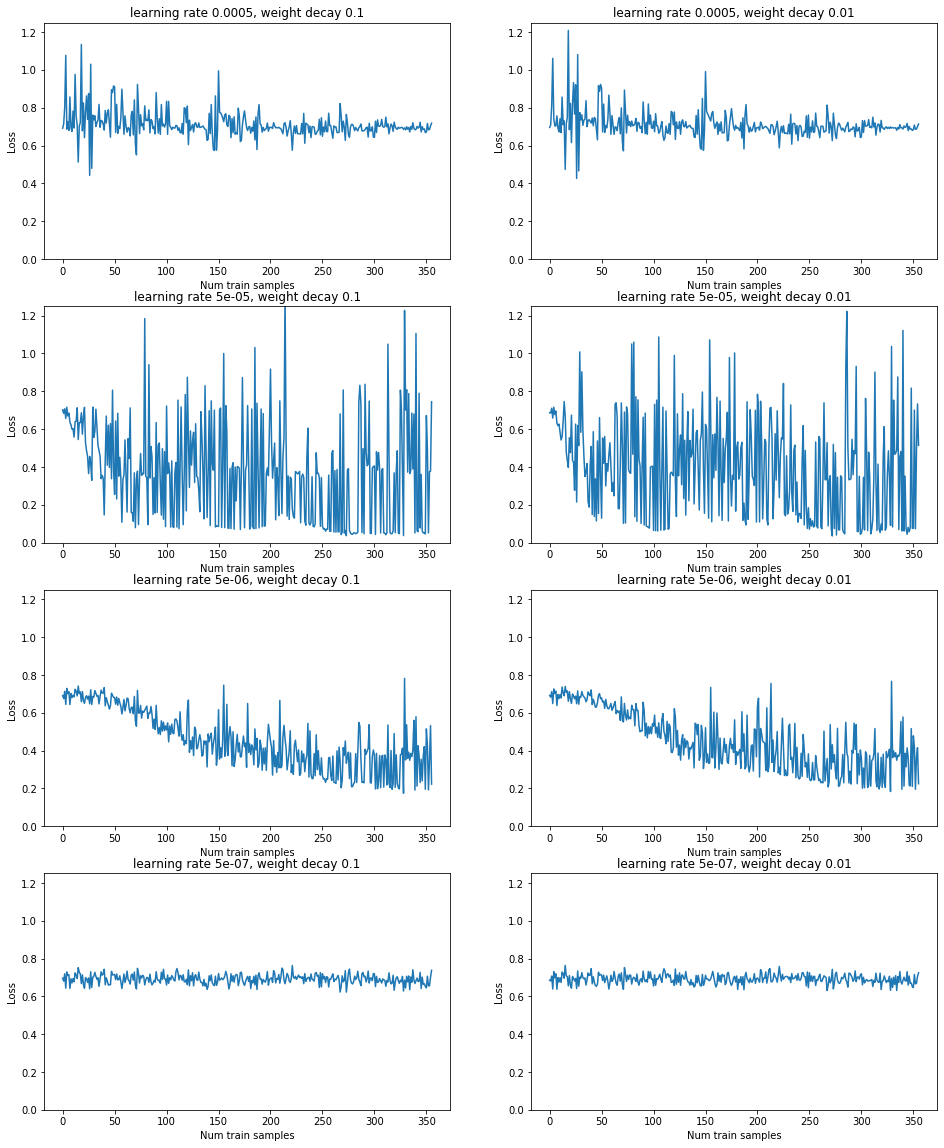

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

grid_search_results_e15 = grid_search_results.loc[grid_search_results['epochs'] == 15]
grid_search_losses_e15 = grid_search_losses.loc[grid_search_results.index]

ce_t = grid_search_losses.transpose()

fig, axs = plt.subplots(4, 2, figsize=(16, 20))  # 4 rows, 2 columns

for i, ax in enumerate(axs.flatten()):
    index = i * 50
    toplot = ce_t[i]
    #toplot.index = 50*np.array(range(len(toplot) // 5))
    ax.plot(toplot)
    ax.set_xticks(np.arange(0, len(toplot), 50)) 
    ax.set_ylim(0.0, 1.25)
    ax.set_title(f"learning rate {grid_search_results['learning_rate'][i]}, weight decay {grid_search_results['weight_decay'][i]}")
    ax.set_xlabel('Num train samples')
    ax.set_ylabel('Loss')

plt.show()

Estas gráficas son algo confusas: el loss parece no seguir un patrón regular. Repintamos las gráficas, sin pintar líneas entre puntos consecutivos

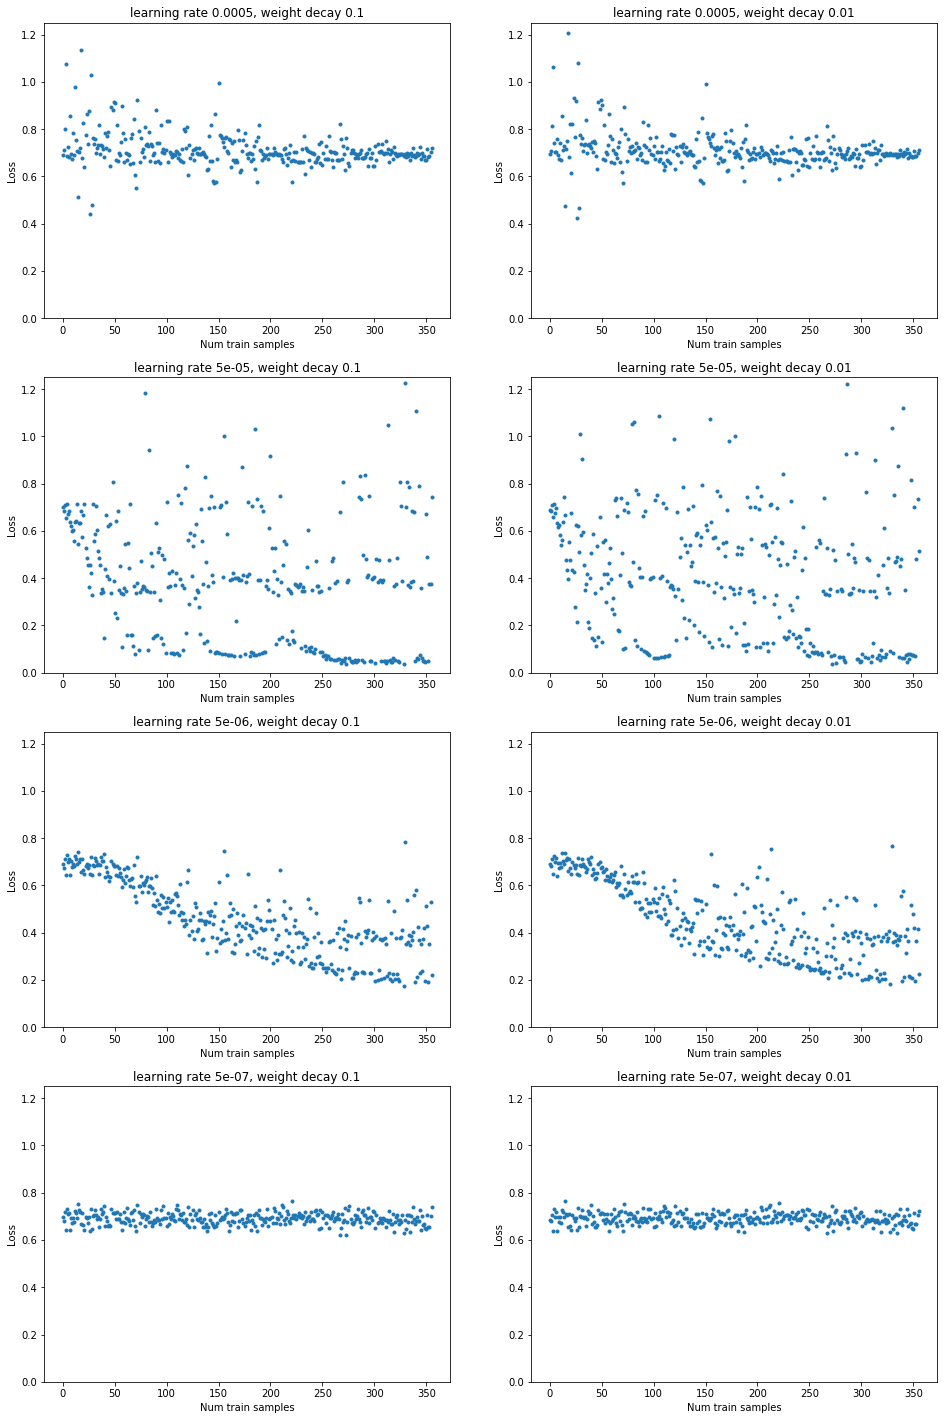

In [52]:
fig, axs = plt.subplots(4, 2, figsize=(16, 25))  # 4 rows, 2 columns

for i, ax in enumerate(axs.flatten()):
    index = i * 50
    toplot = ce_t[i]
    #toplot.index = 50*np.array(range(len(toplot) // 5))
    ax.plot(toplot, '.')
    ax.set_xticks(np.arange(0, len(toplot), 50)) 
    ax.set_ylim(0.0, 1.25)
    ax.set_title(f"learning rate {grid_search_results['learning_rate'][i]}, weight decay {grid_search_results['weight_decay'][i]}")
    ax.set_xlabel('Num train samples')
    ax.set_ylabel('Loss')

plt.show()

Con estas gráficas ya podemos obtener algunos detalles relevantes:

  - El aprendizaje del modelo no es uniforme respecto de todos los ejemplos, sino que algunos ejemplos se entienden muy bien con el aprendizaje y otros se entienden cada vez menos a medida que el entrenamiento continúa.
  
  - El weight decay no afecta a la evolución de la pérdida o *loss*, por la similitud de las gráficas al mismo nivel horizontal.
  
  - Un learning rate de $10^{-4}$ da lugar a una pérdida oscilatoria a lo largo del entrenamiento, que indica claramente que es demasiado alto.
  
  - El learning rate de $10^{-7}$ da lugar a una serie de puntos estable en torno a $0.7$. Este valor estacionario indica que el learning rate es demasiado bajo.
  
  - Con learning rate de $10^{-6}$ y (especialmente) de $10^{-5}$ se observa que en realidad se pueden diferenciar cuatro subseries de pérdidas: dos de ellas decrecen hacia el valor cero, y dos de ellas crecen, indicando mayor pérdida conforme aprende el modelo.
  
Vamos a pintar ahora los valores de pérdida con learning rate $10^{-6}$ y weight decay $0.01$, pero usando un *batch_size* de 1 para poder pintar cada loss de diferente color en función de las etiquetas reales y predichas. Para ello entrenamos el modelo una vez más:

In [15]:
import pandas as pd

BATCH_SIZE = 1
SEED = 0

train_df = pd.read_csv('./datasets/all_veltri_2.csv', index_col = 0).sample(frac=1, random_state=SEED)
test_df_pos = pd.read_csv('./datasets/veltri_dramp_cdhit_90_2.csv', index_col = 0)
test_df_neg = pd.read_csv('./datasets/non_amp_ampep_cdhit90_2.csv', index_col = 0)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1, random_state=SEED)

train_dataloader = AMP_DataLoader(train_df, batch_size = BATCH_SIZE)
test_dataloader = AMP_DataLoader(test_df, batch_size = BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
multi_gpu_bert = MultiGPUBertForSequenceClassification(bert_model)

optimizer = AdamW(
    multi_gpu_bert.parameters(), 
    lr = 5e-6,
    betas = (0.9, 0.999),
    eps = 1e-8,
    weight_decay = 0.01,
    amsgrad=False
)

total_steps = len(train_dataloader)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps = total_steps
)

labels, predicted, losses = train_model(multi_gpu_bert, train_dataloader, torch.nn.CrossEntropyLoss(), optimizer, scheduler, verbose = False)

pd.DataFrame(labels).to_csv('results/train_e6_labels.csv', index=False)
pd.DataFrame(predicted).to_csv('results/train_e6_predicted.csv', index=False)  
pd.DataFrame(losses).to_csv('results/train_e6_losses.csv', index=False)  

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [15]:
labels = pd.read_csv('results/train_e6_labels.csv')["0"]
predicted = pd.read_csv('results/train_e6_predicted.csv')["0"]
losses = pd.read_csv('results/train_e6_losses.csv')["0"]

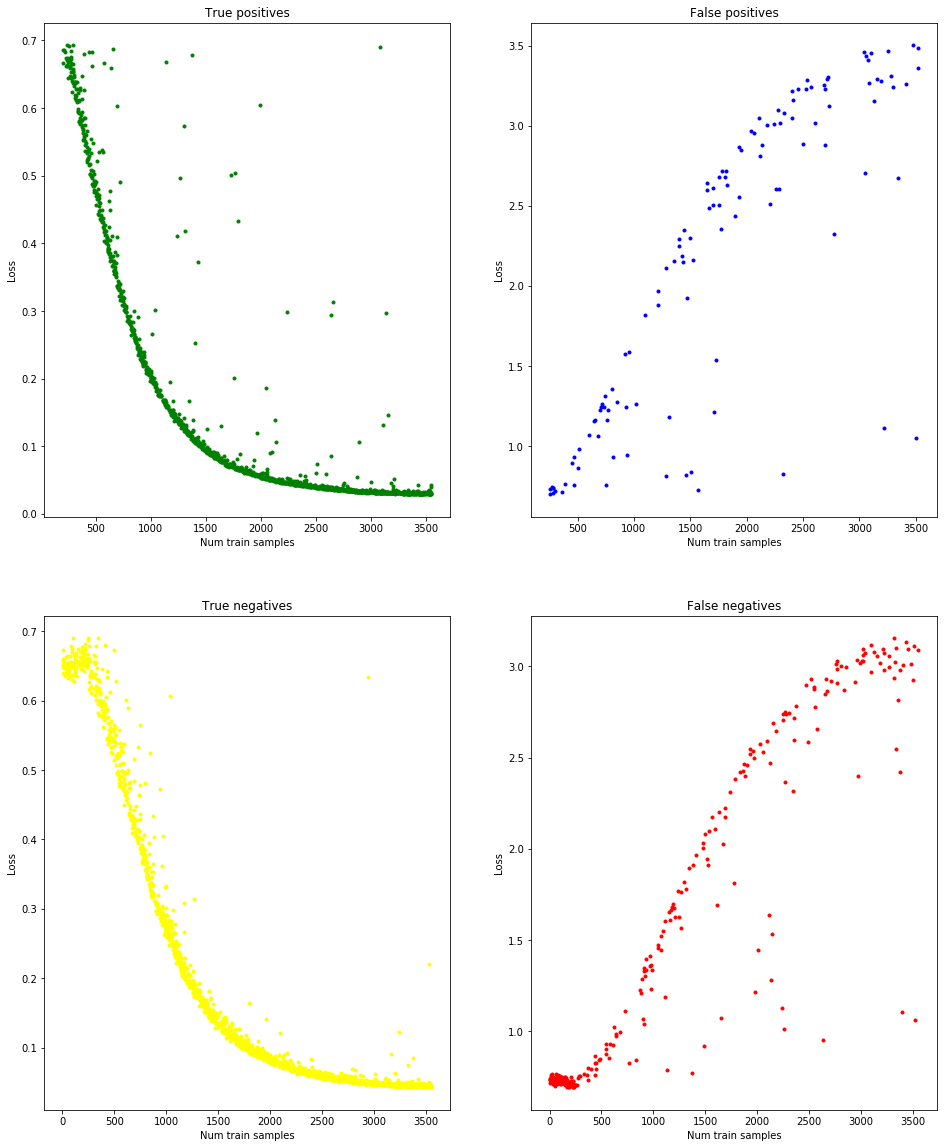

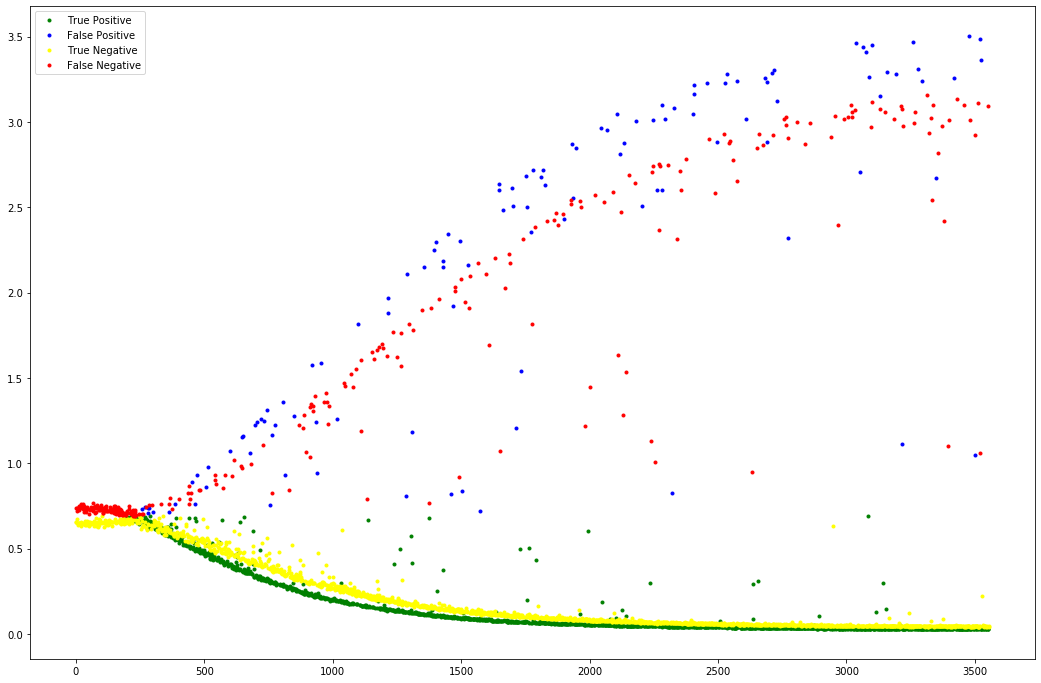

In [16]:
import matplotlib.pyplot as plt

TP = [i for i in range(len(labels)) if labels[i] == 1 and predicted[i] == 1]
FP = [i for i in range(len(labels)) if labels[i] == 0 and predicted[i] == 1]
TN = [i for i in range(len(labels)) if labels[i] == 0 and predicted[i] == 0]
FN = [i for i in range(len(labels)) if labels[i] == 1 and predicted[i] == 0]

TP_losses = [losses[i] for i in TP]
FP_losses = [losses[i] for i in FP]
TN_losses = [losses[i] for i in TN]
FN_losses = [losses[i] for i in FN]

fig, axs = plt.subplots(2, 2, figsize=(16, 20))  # 4 rows, 2 columns

axs[0][0].plot(TP, TP_losses, '.', color='green')
axs[0][0].set_title("True positives")
axs[0][0].set_xlabel('Num train samples')
axs[0][0].set_ylabel('Loss')

axs[0][1].plot(FP, FP_losses, '.', color='blue')
axs[0][1].set_title("False positives")
axs[0][1].set_xlabel('Num train samples')
axs[0][1].set_ylabel('Loss')

axs[1][0].plot(TN, TN_losses, '.', color='yellow')
axs[1][0].set_title("True negatives")
axs[1][0].set_xlabel('Num train samples')
axs[1][0].set_ylabel('Loss')

axs[1][1].plot(FN, FN_losses, '.', color='red')
axs[1][1].set_title("False negatives")
axs[1][1].set_xlabel('Num train samples')
axs[1][1].set_ylabel('Loss')

plt.figure(figsize=(18,12))

plt.plot(TP, TP_losses, '.', color='green', label="True Positive")
plt.plot(FP, FP_losses, '.', color='blue', label="False Positive")
plt.plot(TN, TN_losses, '.', color='yellow', label="True Negative")
plt.plot(FN, FN_losses, '.', color='red', label="False Negative")

plt.legend()
plt.show()

De esta forma, acabamos de comprobar varias cosas:

  - Si bien es normal que los ejemplos que suponen un falso positivo y falso negativo en las predicciones del modelo den lugar a un loss mayor, este loss crece a medida que el entrenamiento continúa. Es decir, cuando el modelo se equivoca, lo hace cada vez con mayor error (*overconfidence*)
  
  - El modelo se equivoca (un poco) más al predecir cadenas de péptidos no antimicrobianos: la serie de puntos azul, correspondiente a péptidos no AMP, presenta valores de pérdida superiores a la series de puntos roja, correspondiente a los péptidos AMP. Ocurre lo mismo con la serie amarilla, cuyos valores son por lo general superiores a los de la serie verde.
  
En resumen,

  * Se han obtenido buenos resultados de training con la configuración del paper inicial
  * Se ha analizado que el weight decay tiene un impacto pequeño pero relevante
  * Es necesario aplicar algún tipo de regularización L1 o L2 para frenar la sobreconfidencia
  * Los ejemplos negativos se analizan un poco peor que los positivos, por lo que podría ser necesario añadir más ejemplos negativos

#### Paso 5: comparar el mejor modelo encontrado con el modelo de referencia

A pesar de que hemos obtenido métricas interesantes para distintas configuraciones de hiperparámetros, es necesario replicar el método empleado en el estudio inicial para obtener métricas sobre los datos de train; esto es, usar una crossvalidación de 10 pliegues sobre el conjunto de train. Se seguirán para ello los siguientes pasos:

  - Se crosvalidará el modelo con el conjunto de train
  - Se obtendrán métricas para el conjunto de train
  - Se compararán los resultados
  
Para obtener métricas sobre los datos de test el método es más sencillo: sólo tenemos que entrenar el modelo con los datos de train, y evaluarlo con el conjunto de test. Una vez obtenidos los resultados, basta comparar las métricas obtenidas con aquellas reportadas en el estudio inicial. Es decir:

  - Se entrenará el modelo con el conjunto de train
  - Se evaluará sobre el conjunto de test
  - Se obtendrán métricas para el conjunto de test
  - Se compararán los resultados

In [13]:
import numpy as np
import pandas as pd
from torch.nn import CrossEntropyLoss

SEED = 0

train_df = pd.read_csv('./datasets/all_veltri_2.csv', index_col = 0).sample(frac=1, random_state=SEED)

bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
multi_gpu_bert = MultiGPUBertForSequenceClassification(bert_model)

model_params = {
    "learning_rate": 5e-6,
    "weight_decay": 0.01,
    "epochs": 15,
    "warmup_steps": 0,
    "batch_size": 8
}

train_metrics = crossvalidate(multi_gpu_bert, train_df, 10, 1, model_params, loss_fn=torch.nn.CrossEntropyLoss(), verbose=True)

train_metrics.to_csv('./results/train_metrics.csv', index = False)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

Crossvalidation: 1 repeat

Crossvalidation: 1 fold

Sample of train data for this split:
                                                            aa_seq    AMP
Unnamed: 0                                                               
UniRef50_A0KYQ6            LQDKWRLSTPGQDYSAFMATLAEQIEKADQQCGERGTVG  False
UniRef50_P0DKY4                          LTDHIIPFWNKLRDDENGGFYGYLS  False
UniRef50_Q94CE5                    LGGNEPRLVSAAVEQLNTLPFYHSFWNRTTK  False
UniRef50_Q19642  QSMKNVEEQLIIMRSKTTNRVEWGTAILACKDFLNDTNMLLEGIGR...  False
UniRef50_Q3MKQ2                    RQPIAHYRWDLMHRVGEPQGRMREENVQRFG  False
UniRef50_A6TB83                     APRFPALWQRFCHFYRQDPLARRRENGLQD  False
AP01178                                  GAWKNFWSSLRKGFYDGEAGRAIRR   True
AP01680                                            ILGIITSLLKSLGKK   True
AP00772           FRGLAKLLKIGLKSFARVLKKVLPKAAKAGKALAKSMADENAIRQQNQ   True
UniRef50_P52023                                  KTENAAATPATEFAVTV  False
UniRef50_Q8TD19  FQIVSA

In [24]:
a2 = train_metrics.copy().transpose()
print()
a2.columns = ["accuracy", "f1", "precision", "recall", "specificity", "auroc","aupr"]
print(a2)
a2.to_csv("./results/cv_train_metrics.csv", index=False)


   accuracy        f1  precision    recall  specificity    auroc      aupr
0  0.929975  0.929566   0.934727  0.925217     0.934762  0.92999  0.948675


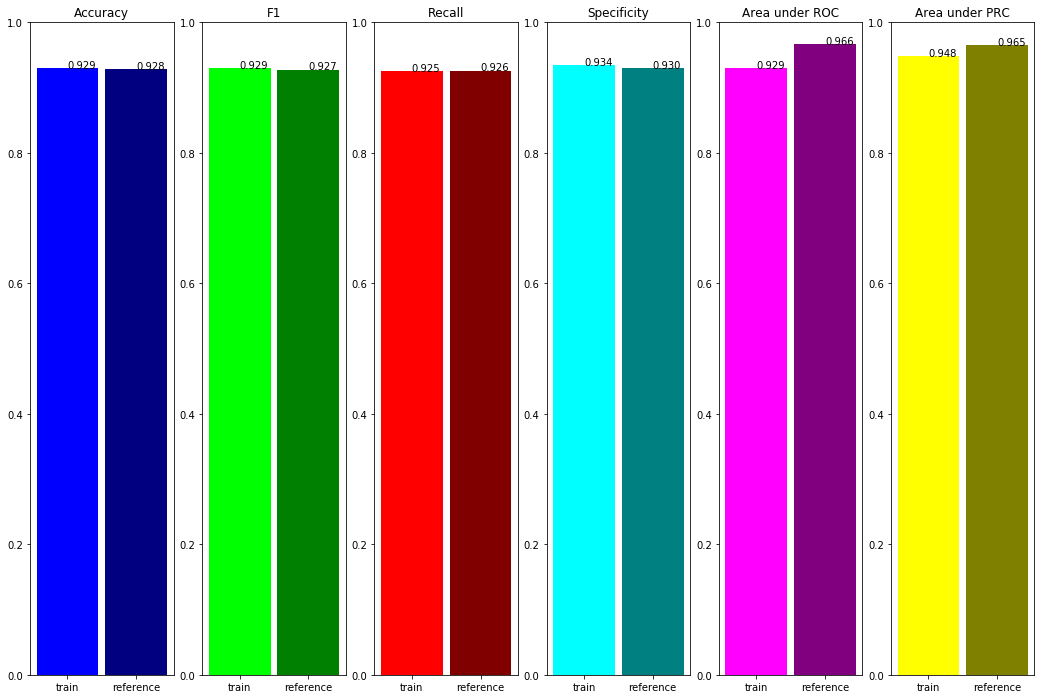

In [27]:
import matplotlib.pyplot as plt

train_metrics = pd.read_csv('./results/cv_train_metrics.csv')
ref_train_metrics = pd.read_csv('./results/ref_metrics_cross_train.csv')

fig, axs = plt.subplots(1, 6, figsize=(18, 12))

w = 0.9

axs[0].bar("train", train_metrics["accuracy"], color=(0.0, 0.0, 1.0, 1.0), width=w)
axs[0].text("train", train_metrics["accuracy"], f'{train_metrics["accuracy"][0]}'[0:5])
axs[0].bar("reference", ref_train_metrics["accuracy"], color=(0.0, 0.0, 0.5, 1.0), width=w)
axs[0].text("reference", ref_train_metrics["accuracy"], f'{ref_train_metrics["accuracy"][0]}'[0:5])
axs[0].set_ylim(0.0, 1.0)
axs[0].set_title("Accuracy")

axs[1].bar("train", train_metrics["f1"], color=(0.0, 1.0, 0.0, 1.0), width=w)
axs[1].text("train", train_metrics["f1"], f'{train_metrics["f1"][0]}'[0:5])
axs[1].bar("reference", ref_train_metrics["f1"], color=(0.0, 0.5, 0.0, 1.0), width=w)
axs[1].text("reference", ref_train_metrics["f1"], f'{ref_train_metrics["f1"][0]}'[0:5])
axs[1].set_ylim(0.0, 1.0)
axs[1].set_title("F1")

axs[2].bar("train", train_metrics["recall"], color=(1.0, 0.0, 0.0, 1.0), width=w)
axs[2].text("train", train_metrics["recall"], f'{train_metrics["recall"][0]}'[0:5])
axs[2].bar("reference", ref_train_metrics["recall"], color=(0.5, 0.0, 0.0, 1.0), width=w)
axs[2].text("reference", ref_train_metrics["recall"], f'{ref_train_metrics["recall"][0]}'[0:5])
axs[2].set_ylim(0.0, 1.0)
axs[2].set_title("Recall")

axs[3].bar("train", train_metrics["specificity"], color=(0.0, 1.0, 1.0, 1.0), width=w)
axs[3].text("train", train_metrics["specificity"], f'{train_metrics["specificity"][0]}'[0:5])
axs[3].bar("reference", ref_train_metrics["specificity"], color=(0.0, 0.5, 0.5, 1.0), width=w)
axs[3].text("reference", ref_train_metrics["specificity"], f'{ref_train_metrics["specificity"][0]}'[0:5])
axs[3].set_ylim(0.0, 1.0)
axs[3].set_title("Specificity")

axs[4].bar("train", train_metrics["auroc"], color=(1.0, 0.0, 1.0, 1.0), width=w)
axs[4].text("train", train_metrics["auroc"], f'{train_metrics["auroc"][0]}'[0:5])
axs[4].bar("reference", ref_train_metrics["auroc"], color=(0.5, 0.0, 0.5, 1.0), width=w)
axs[4].text("reference", ref_train_metrics["auroc"], f'{ref_train_metrics["auroc"][0]}'[0:5])
axs[4].set_ylim(0.0, 1.0)
axs[4].set_title("Area under ROC")

axs[5].bar("train", train_metrics["aupr"], color=(1.0, 1.0, 0.0, 1.0), width=w)
axs[5].text("train", train_metrics["aupr"], f'{train_metrics["aupr"][0]}'[0:5])
axs[5].bar("reference", ref_train_metrics["aupr"], color=(0.5, 0.5, 0.0, 1.0), width=w)
axs[5].text("reference", ref_train_metrics["aupr"], f'{ref_train_metrics["aupr"][0]}'[0:5])
axs[5].set_ylim(0.0, 1.0)
axs[5].set_title("Area under PRC")

plt.show()

In [14]:
import numpy as np
from torch.nn import CrossEntropyLoss

BATCH_SIZE = 8
SEED = 0

train_df = pd.read_csv('./datasets/all_veltri_2.csv', index_col = 0).sample(frac=1, random_state=SEED)
test_df_pos = pd.read_csv('./datasets/veltri_dramp_cdhit_90_2.csv', index_col = 0)
test_df_neg = pd.read_csv('./datasets/non_amp_ampep_cdhit90_2.csv', index_col = 0)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1, random_state=SEED)

train_dataloader = AMP_DataLoader(train_df, batch_size = BATCH_SIZE)
test_dataloader = AMP_DataLoader(test_df, batch_size = BATCH_SIZE)

# Se obtiene la mejor configuración
grid_search_results = pd.read_csv('results/grid_search_results.csv')
grid_search_losses = pd.read_csv('results/grid_search_losses.csv')
best = np.argmax(grid_search_results["f1"])

bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
multi_gpu_bert = MultiGPUBertForSequenceClassification(bert_model)

# Preparamos el optimizador y el scheduler
optimizer = AdamW(
    multi_gpu_bert.parameters(), 
    lr = grid_search_results["learning_rate"][best],
    betas = eval(grid_search_results["betas"][best]),
    eps = grid_search_results["epsilon"][best],
    weight_decay = grid_search_results["weight_decay"][best]
)
        
total_steps = len(train_df) * grid_search_results["epochs"][best]

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps = total_steps
)

# Entrenamos
for epoch in range(grid_search_results["epochs"][best]):
    _, _, losses = train_model(multi_gpu_bert, train_dataloader, CrossEntropyLoss(), optimizer, scheduler)
        
# Medimos
test_labels, test_predictions = eval_model(multi_gpu_bert, test_dataloader, CrossEntropyLoss())

test_metrics = compute_metrics(test_labels, test_predictions)

pd.Series(losses).to_csv('./results/train_losses.csv', index = False)
train_metrics.to_csv('./results/train_metrics.csv', index = False)
test_metrics.to_csv('./results/test_metrics.csv', index = False)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

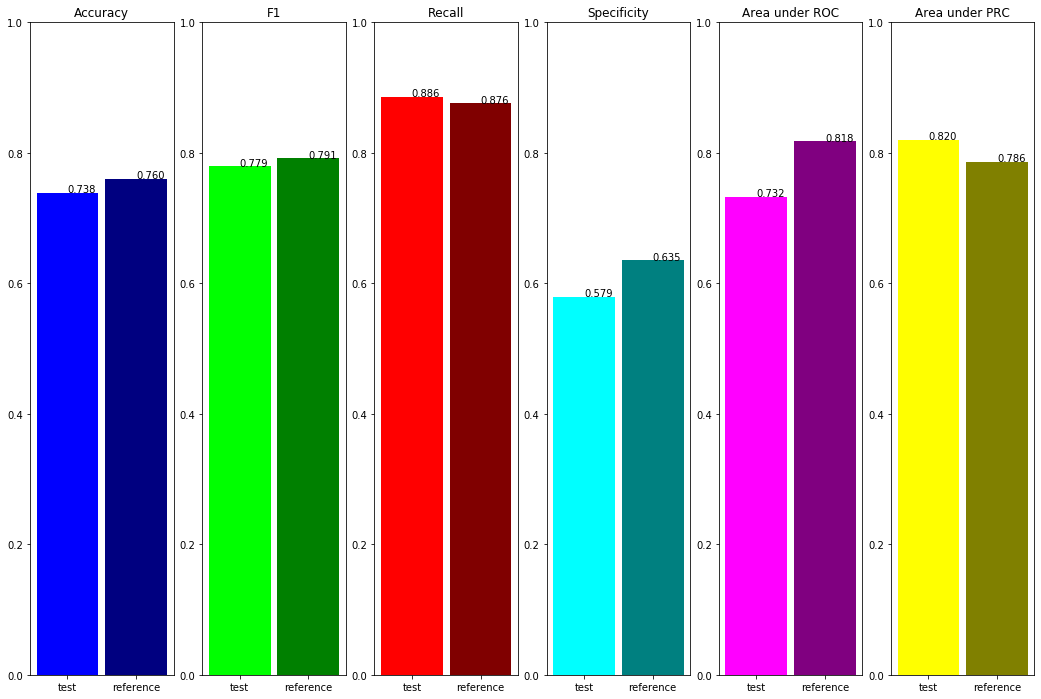

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

ref_test_metrics = pd.read_csv('./results/ref_metrics_test.csv')
test_metrics = pd.read_csv('./results/test_metrics.csv')

fig, axs = plt.subplots(1, 6, figsize=(18, 12))

w = 0.9

axs[0].bar("test", test_metrics["accuracy"], color=(0.0, 0.0, 1.0, 1.0), width=w)
axs[0].text("test", test_metrics["accuracy"], f'{test_metrics["accuracy"][0]}'[0:5])
axs[0].bar("reference", ref_test_metrics["accuracy"], color=(0.0, 0.0, 0.5, 1.0), width=w)
axs[0].text("reference", ref_test_metrics["accuracy"], f'{ref_test_metrics["accuracy"][0]}'[0:5])
axs[0].set_ylim(0.0, 1.0)
axs[0].set_title("Accuracy")

axs[1].bar("test", test_metrics["f1"], color=(0.0, 1.0, 0.0, 1.0), width=w)
axs[1].text("test", test_metrics["f1"], f'{test_metrics["f1"][0]}'[0:5])
axs[1].bar("reference", ref_test_metrics["f1"], color=(0.0, 0.5, 0.0, 1.0), width=w)
axs[1].text("reference", ref_test_metrics["f1"], f'{ref_test_metrics["f1"][0]}'[0:5])
axs[1].set_ylim(0.0, 1.0)
axs[1].set_title("F1")

axs[2].bar("test", test_metrics["recall"], color=(1.0, 0.0, 0.0, 1.0), width=w)
axs[2].text("test", test_metrics["recall"], f'{test_metrics["recall"][0]}'[0:5])
axs[2].bar("reference", ref_test_metrics["recall"], color=(0.5, 0.0, 0.0, 1.0), width=w)
axs[2].text("reference", ref_test_metrics["recall"], f'{ref_test_metrics["recall"][0]}'[0:5])
axs[2].set_ylim(0.0, 1.0)
axs[2].set_title("Recall")

axs[3].bar("test", test_metrics["specificity"], color=(0.0, 1.0, 1.0, 1.0), width=w)
axs[3].text("test", test_metrics["specificity"], f'{test_metrics["specificity"][0]}'[0:5])
axs[3].bar("reference", ref_test_metrics["specificity"], color=(0.0, 0.5, 0.5, 1.0), width=w)
axs[3].text("reference", ref_test_metrics["specificity"], f'{ref_test_metrics["specificity"][0]}'[0:5])
axs[3].set_ylim(0.0, 1.0)
axs[3].set_title("Specificity")

axs[4].bar("test", test_metrics["auroc"], color=(1.0, 0.0, 1.0, 1.0), width=w)
axs[4].text("test", test_metrics["auroc"], f'{test_metrics["auroc"][0]}'[0:5])
axs[4].bar("reference", ref_test_metrics["auroc"], color=(0.5, 0.0, 0.5, 1.0), width=w)
axs[4].text("reference", ref_test_metrics["auroc"], f'{ref_test_metrics["auroc"][0]}'[0:5])
axs[4].set_ylim(0.0, 1.0)
axs[4].set_title("Area under ROC")

axs[5].bar("test", test_metrics["aupr"], color=(1.0, 1.0, 0.0, 1.0), width=w)
axs[5].text("test", test_metrics["aupr"], f'{test_metrics["aupr"][0]}'[0:5])
axs[5].bar("reference", ref_test_metrics["aupr"], color=(0.5, 0.5, 0.0, 1.0), width=w)
axs[5].text("reference", ref_test_metrics["aupr"], f'{ref_test_metrics["aupr"][0]}'[0:5])
axs[5].set_ylim(0.0, 1.0)
axs[5].set_title("Area under PRC")

plt.show()

Las métricas sobre los datos de test están muy cerca de las métricas reportadas por el paper de referencia: hemos logrado replicar el modelo con un nivel satisfactorio de rendimiento.

Sin embargo, las métricas sobre el test set son marcadamente inferiores con respecto a las métricas del training set. La reducción está en torno a $0.15$, con algunas diferencias entre métricas.

## Conclusiones

Tanto la diferencia de resultados en las métricas sobre el *train set* y el *test set*, como la evolución del error durante el entrenamiento dejan ver que el modelo ha alcanzado un mínimo local y no es capaz de mejorar y aprender.

Tanto la sobreconfidencia como un bajo rendimiento en las métricas de *test* son síntomas de *overfitting*: el modelo se sobreajusta a los datos de los que disponemos y no es capaz de generalizar bien al resto de datos. Para entender si pasa esto y por qué, habrá que estudiar el comportamiento de las capas del modelo durante el aprendizaje, y aplicar las técnicas más apropiadas para resolver los obstáculos encontrados: regularización de pesos, congelación de capas, etc... 

Sin embargo, el problema podría no ser un overfitting, puesto que se obtienen resultados de validación buenos con respecto a los resultados sobre el training set. Puede que simplemente el modelo no sea capaz de aprender a resolver el problema con los datos de entrenamiento, y necesite de muchos más datos para entender el problema bien. En caso de que fuera así, concluiríamos que el clasificador lineal se queda corto respecto a la magnitud del problema: necesitaríamos un clasificador más complejo, que sea capaz de entender patrones no lineales en los embeddings que genera el submodelo BERT.

### Extra: resultados adicionales

#### Efecto del *batch_size* sobre el modelo

El tamaño de batch o *batch_size* controla el número de ejemplos que procesa el modelo en paralelo. Este hiperparámetro es independiente del resto, y sabemos que a menor valor, mayor tiempo necesario para entrenarlo. Ahora bien, ¿sale a cuenta usar tamaños grandes, teniendo en cuenta las limitaciones de memoria de las que disponemos?

Probamos todos los múltiplos de 2 para el *batch_size*, con el propósito inicial de comprobar qué tamaños se pueden usar para este valor:

In [17]:
import pandas as pd

# Se leen los datos de train y test
SEED = 42

train_df = pd.read_csv('./datasets/all_veltri.csv', index_col = 0).sample(frac=1, random_state=SEED)
test_df_pos = pd.read_csv('./datasets/veltri_dramp_cdhit_90.csv', index_col = 0)
test_df_neg = pd.read_csv('./datasets/non_amp_ampep_cdhit90.csv', index_col = 0)

test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1, random_state=SEED)

batch_sizes = [1,2,4,8,16,32]
train_dataloaders = []
test_dataloaders = []

for bs in batch_sizes:
    train_dataloaders.append(AMP_DataLoader(train_df, batch_size = bs))
    test_dataloaders.append(AMP_DataLoader(test_df, batch_size = bs))

In [9]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from time import process_time_ns 
from copy import deepcopy
import pandas as pd

#bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
#multi_gpu_bert = MultiGPUBertForSequenceClassification(bert_model)

used_batch_sizes = []

for batch_size, train_dataloader, test_dataloader in zip(batch_sizes, train_dataloaders, test_dataloaders):
    try:
        model_copy = deepcopy(multi_gpu_bert)
        
        optimizer = AdamW(
            model_copy.parameters(), 
            lr = 1e-5,
            betas = (0.9, 0.999),
            eps = 1e-8,
            weight_decay = 0.1,
            amsgrad=False
        )
        
        total_steps = len(train_dataloader)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps = 0, 
            num_training_steps = total_steps
        )
    
        print(f"Train with batch_size = {batch_size}")
        train_model(model_copy, train_dataloader, torch.nn.CrossEntropyLoss(), optimizer, scheduler, verbose = False)        
        print(f"Training complete")
        used_batch_sizes.append(batch_size)
        
        del model_copy

    except:
        print(f"Training failed with batch_size = {batch_size}. Aborting.")
        del model_copy
        
        break

Train with batch_size = 1
Training complete
Train with batch_size = 2
Training complete
Train with batch_size = 4
Training complete
Train with batch_size = 8
Training complete
Training failed with batch_size = 16. Aborting.


De esta forma, sólo se puede usar un tamaño de batch hasta 8. Veamos ahora los resultados que ofrece cada configuración, usando un grid search sobre los valores que sabemos que podemos probar para este hiperparámetro.

In [17]:
grid_batch_size = {
    "epochs": [1],
    "batch_size": used_batch_sizes,
    "learning_rate": [1e-5],
    "betas": [(0.9, 0.999)],
    "epsilon": [1e-8],
    "weight_decay": [0.1],
    "loss_functions": [
        torch.nn.CrossEntropyLoss()
    ]
}

# Busco en un grid
batch_size_results, batch_size_losses = grid_search_bert_model(multi_gpu_bert, train_df, grid_batch_size)

# Guardo los resultados
batch_size_results.to_csv('results/batch_size_results.csv', index=False)
batch_size_losses.to_csv('results/batch_size_losses.csv', index=False)


Number of combinations: 4

Next combination:
epochs: 1
batch_size: 1
learning_rate: 1e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
loss_fn: CrossEntropyLoss()

Next combination:
epochs: 1
batch_size: 2
learning_rate: 1e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
loss_fn: CrossEntropyLoss()

Next combination:
epochs: 1
batch_size: 4
learning_rate: 1e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
loss_fn: CrossEntropyLoss()

Next combination:
epochs: 1
batch_size: 8
learning_rate: 1e-05
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.1
loss_fn: CrossEntropyLoss()


In [19]:
batch_size_results = pd.read_csv('results/batch_size_results.csv')
batch_size_losses = pd.read_csv('results/batch_size_losses.csv')

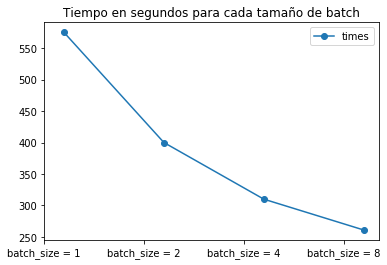

In [24]:
import matplotlib.pyplot as plt
import numpy as np

index = np.arange(len(batch_size_results.index))
tags = [f"batch_size = {bs}" for bs in used_batch_sizes]

w = 0.4

n = len(used_batch_sizes)



plt.plot(index, batch_size_results["train_time_secs"], 'o-', label="times")

plt.xticks(index - w/2, tags)
plt.legend()
plt.title("Tiempo en segundos para cada tamaño de batch")
plt.show()

       

Vemos que el tiempo decrece casi logarítmicamente con respecto al tamaño de batch. En concreto, un tamaño de batch de 8 da lugar a una disminución del tiempo usado, hasta aproximadamente la mitad del tiempo necesario usando tamaño de batch 1.

Ahora veamos si el rendimiento del modelo se ve afectado por el cambio en el tamaño de batch:

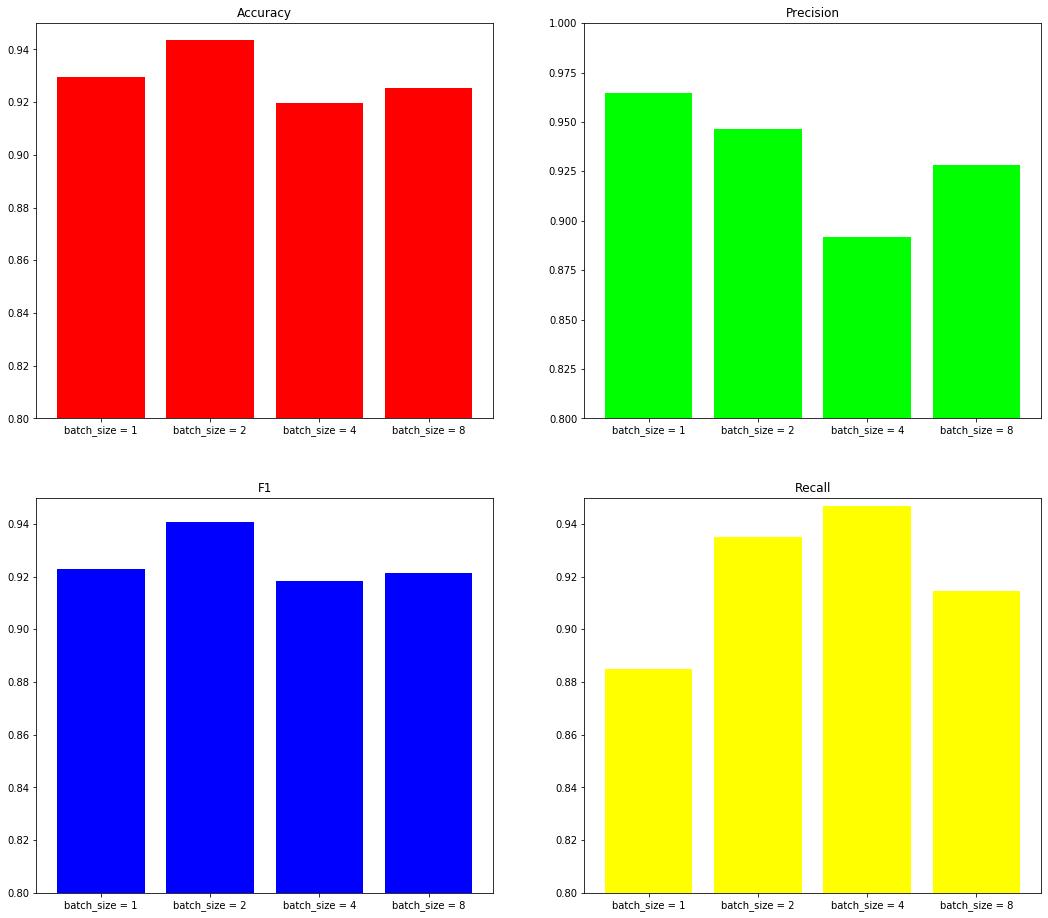

In [33]:
import pandas as pd

fig, axs = plt.subplots(2, 2, figsize=(18, 16))

axs[0][0].bar(index, batch_size_results["accuracy"], color = (1,0,0))
axs[0][0].set_xticks(index)
axs[0][0].set_xticklabels(tags)
axs[0][0].set_ylim((0.8,0.95))
axs[0][0].set_title("Accuracy")

axs[0][1].bar(index, batch_size_results["precision"], color = (0,1,0))
axs[0][1].set_xticks(index)
axs[0][1].set_xticklabels(tags)
axs[0][1].set_ylim((0.8,1))
axs[0][1].set_title("Precision")


axs[1][0].bar(index, batch_size_results["f1"], color = (0,0,1))
axs[1][0].set_xticks(index)
axs[1][0].set_xticklabels(tags)
axs[1][0].set_ylim((0.8,0.95))
axs[1][0].set_title("F1")

axs[1][1].bar(index, batch_size_results["recall"], color = (1,1,0))
axs[1][1].set_xticks(index)
axs[1][1].set_xticklabels(tags)
axs[1][1].set_ylim((0.8,0.95))
axs[1][1].set_title("Recall")

plt.show()

Las métricas no parecen cambiar demasiado: la F1 nos permite ver que el baremo general entre precisión y recall no cambia demasiado entre las diferentes configuraciones, en torno a $0.92$. Las diferencias (muy pequeñas, basta mirar la escala de las gráficas) parece estar en que con un tamaño de batch algo mayor el modelo parece mostrar ligeramente más recall y menor precisión: clasifica como AMP más ejemplos, aunque algunos no sean AMP.

En el siguiente plot se muestra la evolución del error para cada tamaño de batch:

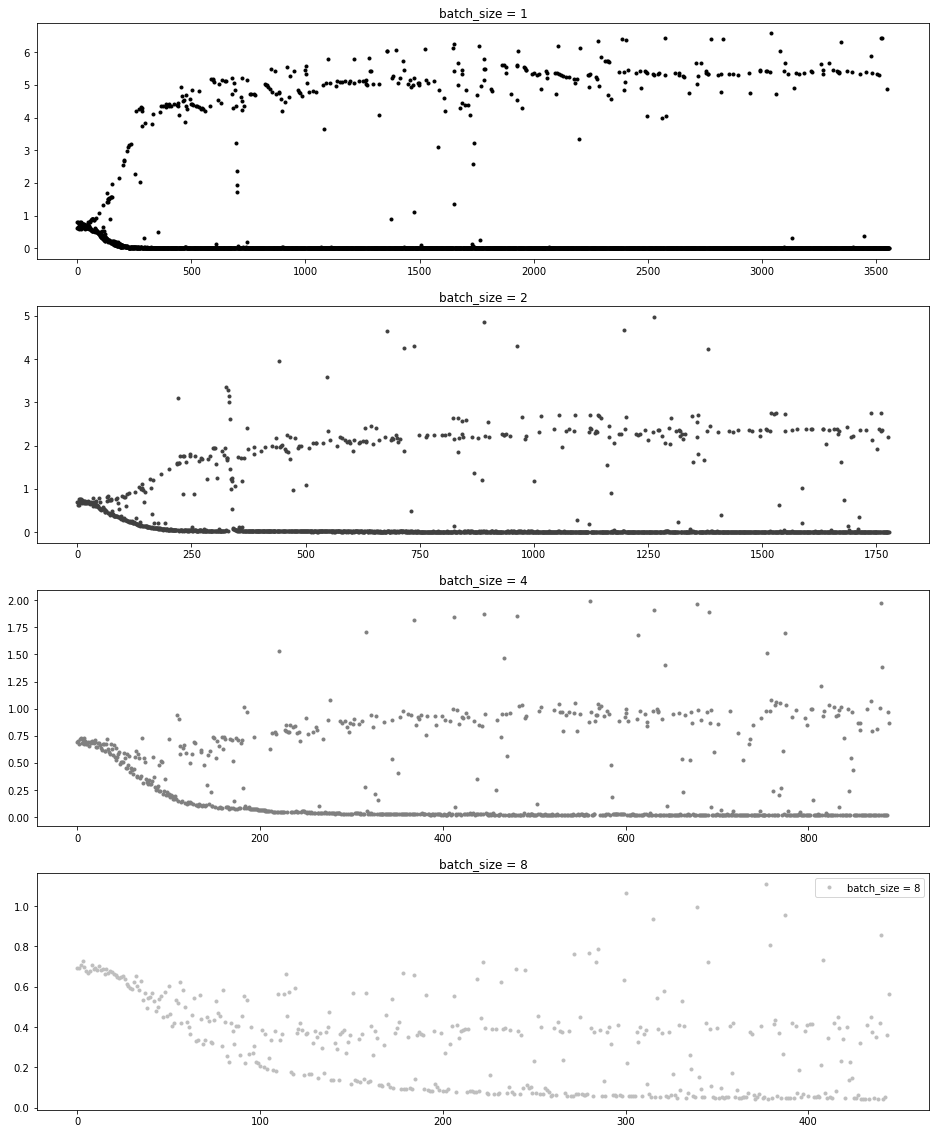

In [101]:

fig, axs = plt.subplots(n, 1, figsize=(16, 20))  # 4 rows, 2 columns

for i in range(n):
    color = (i/len(used_batch_sizes),(i/len(used_batch_sizes)),(i/len(used_batch_sizes)))
    axs[i].plot(range(len(all_losses[i])), all_losses[i], '.', color=color, label=f"batch_size = {used_batch_sizes[i]}")
    axs[i].set_title(f"batch_size = {used_batch_sizes[i]}")
    
plt.legend()
plt.show()

El fenómeno observado es que el error parece aumentar, y los ejemplos que se clasifican muy mal parece disminuir. Sin embargo, nada más lejos de la realidad: puesto que ahora los ejemplos se agrupan en grupos, los que se clasifican muy mal se unen con otros que se clasifican muy bien, subiendo el error medio.